In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import geopandas as gpd
from statistics import mean
import folium
import matplotlib.dates as mdates 
import warnings
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from scipy.stats import ttest_ind
from matplotlib.colors import ListedColormap

warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv("Crime_Data_from_2020_to_Present.csv")

df.head(5)

DR_NO       Date Rptd        DATE OCC  TIME OCC  AREA    AREA NAME  \
0   10304468   1/8/2020 0:00   1/8/2020 0:00      2230     3    Southwest   
1  190101086   1/2/2020 0:00   1/1/2020 0:00       330     1      Central   
2  200110444  4/14/2020 0:00  2/13/2020 0:00      1200     1      Central   
3  191501505   1/1/2020 0:00   1/1/2020 0:00      1730    15  N Hollywood   
4  191921269   1/1/2020 0:00   1/1/2020 0:00       415    19      Mission   

   Rpt Dist No  Part 1-2  Crm Cd  \
0          377         2     624   
1          163         2     624   
2          155         2     845   
3         1543         2     745   
4         1998         2     740   

                                         Crm Cd Desc  ... Status  \
0                           BATTERY - SIMPLE ASSAULT  ...     AO   
1                           BATTERY - SIMPLE ASSAULT  ...     IC   
2          SEX OFFENDER REGISTRANT OUT OF COMPLIANCE  ...     AA   
3           VANDALISM - MISDEAMEANOR ($399 OR UNDER)  ...     IC   
4  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  ...     IC   

    Status Desc Crm Cd 1 Crm Cd 2  Crm Cd 3 Crm Cd 4  \
0   Adult Other    624.0      NaN       NaN      NaN   
1   Invest Cont    624.0      NaN       NaN      NaN   
2  Adult Arrest    845.0      NaN       NaN      NaN   
3   Invest Cont    745.0    998.0       NaN      NaN   
4   Invest Cont    740.0      NaN       NaN      NaN   

                                   LOCATION Cross Street      LAT       LON  
0   1100 W  39TH                         PL          NaN  34.0141 -118.2978  
1    700 S  HILL                         ST          NaN  34.0459 -118.2545  
2    200 E  6TH                          ST          NaN  34.0448 -118.2474  
3   5400    CORTEEN                      PL          NaN  34.1685 -118.4019  
4  14400    TITUS                        ST          NaN  34.2198 -118.4468  

[5 rows x 28 columns]

In [2]:
#list of columns
print(df.columns)

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')


In [3]:
# null values in each column
df.isna().sum()

DR_NO                  0
Date Rptd              0
DATE OCC               0
TIME OCC               0
AREA                   0
AREA NAME              0
Rpt Dist No            0
Part 1-2               0
Crm Cd                 0
Crm Cd Desc            0
Mocodes           112024
Vict Age               0
Vict Sex          106524
Vict Descent      106532
Premis Cd              9
Premis Desc          479
Weapon Used Cd    528880
Weapon Desc       528880
Status                 0
Status Desc            0
Crm Cd 1              10
Crm Cd 2          751848
Crm Cd 3          809663
Crm Cd 4          811603
LOCATION               0
Cross Street      681791
LAT                    0
LON                    0
dtype: int64

# Data Cleaning

In [4]:
#Changing 'Date Rptd' Format
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
df['Date Rptd'] = df['Date Rptd'].dt.date

# Changing 'Date OCC' format
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])
df['DATE OCC'] = df['DATE OCC'].dt.date


In [5]:
#Changing 'TIME OCC' format
df['TIME OCC'] = df['TIME OCC'].astype(str).str.zfill(4)
df['TIME OCC'] = pd.to_datetime(df['TIME OCC'], format = '%H%M').dt.time


In [6]:
#cleaning Rpt Dist No
print(df.tail())

print(df.describe(include='all'))
print(df.dtypes)

df['Rpt Dist No'].isna().sum()
rpt_dist_no=df.groupby('AREA NAME')
df['Rpt Dist No'].value_counts()
print("count of unique rpt dist no:",len(df['Rpt Dist No'].unique()))
print(np.sort(df['Rpt Dist No'].unique()))
print(df.loc[:,['Rpt Dist No','AREA NAME']].drop_duplicates().head(30))
print("count of unique area names:",len(df['AREA NAME'].unique()))
print(df['AREA NAME'].unique())

#cleaning Crm Cd and Crm Cd Desc
df['Crm Cd'].isna().sum()
print("number of unique crime code/types:",len(df['Crm Cd'].unique()))
print(np.sort(df['Crm Cd'].unique()))

df['Crm Cd Desc'].isna().sum()
print("number of unique crime code/types description:",len(df['Crm Cd Desc'].unique()))

df['Mocodes'].fillna('0000',inplace=True)
print(df['Mocodes'].isna().sum())

# Cleaning Age
# Age does not have null values but has negative entries which can be filled with mean
# print(df['Vict Age'].isna().sum())
# print(df[df['Vict Age']<=0].shape)
# print(df[df['Vict Age']<0].head(10))

# mean_age=df.loc[df['Vict Age']>0,'Vict Age'].mean()
# df.loc[df['Vict Age']<=0,'Vict Age']=mean_age
# print(df[df['Vict Age']<=0])

            DR_NO   Date Rptd    DATE OCC  TIME OCC  AREA    AREA NAME  \
811658  231604807  2023-01-27  2023-01-26  18:00:00    16     Foothill   
811659  231606525  2023-03-22  2023-03-22  10:00:00    16     Foothill   
811660  231210064  2023-04-12  2023-04-12  16:30:00    12  77th Street   
811661  230115220  2023-07-02  2023-07-01  00:01:00     1      Central   
811662  230906458  2023-03-05  2023-03-05  09:00:00     9     Van Nuys   

        Rpt Dist No  Part 1-2  Crm Cd  \
811658         1663         2     740   
811659         1602         1     230   
811660         1239         1     230   
811661          154         1     352   
811662          914         2     745   

                                              Crm Cd Desc  ... Status  \
811658  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  ...     IC   
811659     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  ...     IC   
811660     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  ...     IC   
811661          

In [7]:
# df['Vict Age'].unique()

In [8]:
#Victim Sex cleaning
print("\nVictim Sex Cleaning")
count = df[~df['Vict Sex'].isin(['M', 'F', 'X'])].shape[0]
print("Number of values in the Vict Sex column which are not M, F or X before cleaning are: ", count)

count_M = 50720
count_F = 45242
count_X = 10652

replace_values = ['M'] * count_M + ['F'] * count_F + ['X'] * count_X

np.random.shuffle(replace_values)

df.loc[~df['Vict Sex'].isin(['M', 'F', 'X']), 'Vict Sex'] = replace_values

countm = df[df['Vict Sex'].isin(['M'])].shape[0]
print("Number of value 'M' after cleaning", countm)
countf = df[df['Vict Sex'].isin(['F'])].shape[0]
print("Number of value 'F' after cleaning", countf)
countx = df[df['Vict Sex'].isin(['X'])].shape[0]
print("Number of value 'X' after cleaning", countx)

count = df[~df['Vict Sex'].isin(['M', 'F', 'X'])].shape[0]
print("Values not containing either M, F or X after cleaning are: ", count)


Victim Sex Cleaning
Number of values in the Vict Sex column which are not M, F or X before cleaning are:  106614
Number of value 'M' after cleaning 386148
Number of value 'F' after cleaning 344328
Number of value 'X' after cleaning 81187
Values not containing either M, F or X after cleaning are:  0


In [9]:
# Vict Descent Cleaning
print("\nVict Descent Cleaning")
count = df[df['Vict Descent'].isin(['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'O', 'P', 'S', 'U', 'V', 'W', 'X', 'Z'])].shape[0]
na_count = df[~df['Vict Descent'].isin(['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'O', 'P', 'S', 'U', 'V', 'W', 'X', 'Z'])].shape[0]
blank_count = df['Vict Descent'].isna().sum()

df['Vict Descent'].fillna('X', inplace=True)
df['Vict Descent'].replace('-', 'X', inplace=True)

na_count = df[~df['Vict Descent'].isin(['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'O', 'P', 'S', 'U', 'V', 'W', 'X', 'Z'])].shape[0]

print("Acceptable values in Vict Descent: ", count)
print("Non-acceptable values in Vict Descent: ", na_count)
print("Blank values in Vict Descent: ", blank_count)

print("Acceptable values in Vict Descent after cleaning: ", df[df['Vict Descent'].isin(['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'O', 'P', 'S', 'U', 'V', 'W', 'X', 'Z'])].shape[0])
print("Blank values after cleaning: ", df['Vict Descent'].isna().sum())
print("Non-acceptable values in the Vict Descent column after cleaning: ", na_count)


Vict Descent Cleaning
Acceptable values in Vict Descent:  705129
Non-acceptable values in Vict Descent:  0
Blank values in Vict Descent:  106532
Acceptable values in Vict Descent after cleaning:  811663
Blank values after cleaning:  0
Non-acceptable values in the Vict Descent column after cleaning:  0


In [10]:
# Premise Code and Premise Description cleaning
# Replacing all the null values of premise cd with 000 and corresponding premise desc to unknown
print("\nPremise code cleaning")
print("Null values in premise code before cleaning: ", df['Premis Cd'].isna().sum())
df['Premis Cd'].fillna(000, inplace=True)
df['Premis Cd'] = df['Premis Cd'].apply(lambda x: f"{x:.1f}")
df['Premis Desc'].fillna("No record", inplace=True)


blank_count = df['Premis Cd'].isna().sum()
print("Null values in premise code after cleaning: ", df['Premis Cd'].isna().sum())


Premise code cleaning
Null values in premise code before cleaning:  9
Null values in premise code after cleaning:  0


In [11]:
# Cleaning Weapon Used Cd and Description
print("\nWeapon Used Cd and Description cleaning")
blank_count = df['Weapon Used Cd'].isna().sum()
print(f"Number of blank values in 'Weapon Used Cd before cleaning': {blank_count}")



df['Weapon Used Cd'].fillna(000, inplace=True)
df['Weapon Used Cd'] = df['Weapon Used Cd'].apply(lambda x: f"{x:.1f}")
df['Weapon Desc'].fillna("No weapon found", inplace=True)


blank_count = df['Weapon Used Cd'].isna().sum()
print(f"Number of blank values in 'Weapon Used Cd after cleaning': {blank_count}")
df['Weapon Used Cd']


Weapon Used Cd and Description cleaning
Number of blank values in 'Weapon Used Cd before cleaning': 528880
Number of blank values in 'Weapon Used Cd after cleaning': 0


0         400.0
1         500.0
2           0.0
3           0.0
4           0.0
          ...  
811658      0.0
811659    400.0
811660    500.0
811661      0.0
811662      0.0
Name: Weapon Used Cd, Length: 811663, dtype: object

In [12]:
#

In [13]:
#

# 1. Overall Crime Trends:
 Calculate and plot the total number of crimes per year to visualize the trends.

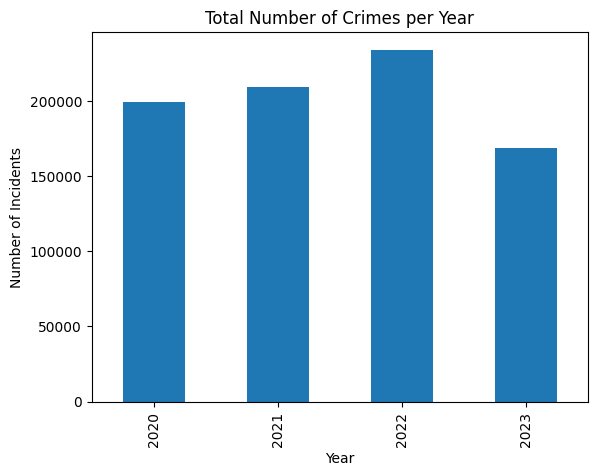

In [14]:
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])
df['Year'] = df['DATE OCC'].dt.year
crime_freq_by_year = df['Year'].value_counts().sort_index()

crime_freq_by_year.plot(kind='bar')
plt.title('Total Number of Crimes per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()


# 2. Seasonal Patterns:
 Group the data by month and analyze the average number of crimes per month over
the yearss

In [15]:
#Finding average number of crimes per month over the years.
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])
df['Month'] = df['DATE OCC'].dt.month_name()
df['Year'] = df['DATE OCC'].dt.year
average_crimes_per_month = df.groupby(['Year', 'Month']).size().groupby('Month').mean()
average_crimes_per_month

Month
April        17547.000000
August       18645.750000
December     17912.000000
February     17148.500000
January      18248.750000
July         18803.000000
June         18183.500000
March        17780.500000
May          18306.500000
November     17514.666667
October      14126.500000
September    17555.750000
dtype: float64

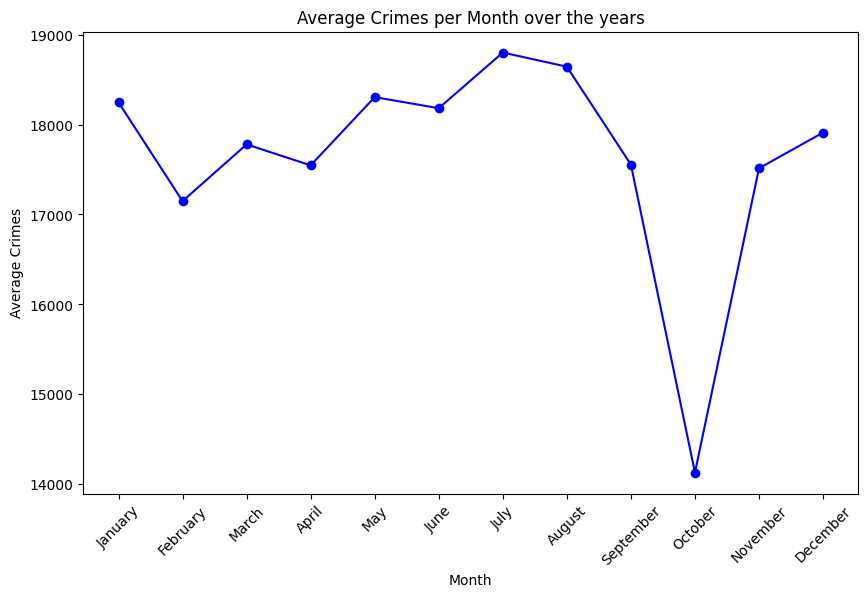

In [16]:
# Define custom month order
custom_month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Sort the data according to the custom month order
average_crimes_per_month = average_crimes_per_month.reindex(custom_month_order)

# Extract months and average crimes from the data
months = average_crimes_per_month.index
average_crimes = average_crimes_per_month.values

plt.figure(figsize=(10, 6))
plt.plot(months, average_crimes, marker='o', linestyle='-', color='b')

plt.title('Average Crimes per Month over the years')
plt.xlabel('Month')
plt.ylabel('Average Crimes')
plt.xticks(rotation=45)

plt.show()

In [17]:
#Grouping data by month and year

avg_cpm_year = df.groupby(['Year', 'Month']).size()
avg_cpm_year_df = pd.DataFrame(avg_cpm_year)
reset_df = avg_cpm_year_df.reset_index()

reset_df

custom_month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Create a mapping of month names to their corresponding numerical values
month_order_mapping = {month: index for index, month in enumerate(custom_month_order)}

# Add a new column to the DataFrame to represent the month order
reset_df['Month_Order'] = reset_df['Month'].map(month_order_mapping)

# Sort the DataFrame based on the 'Month_Order' column
reset_df = reset_df.sort_values(by=['Year', 'Month_Order'])

# Drop the 'Month_Order' column if you no longer need it
reset_df = reset_df.drop('Month_Order', axis=1)
reset_df

Year      Month      0
4   2020    January  18479
3   2020   February  17252
7   2020      March  16157
0   2020      April  15676
8   2020        May  17200
6   2020       June  17028
5   2020       July  17114
1   2020     August  16869
11  2020  September  15631
10  2020    October  16482
9   2020   November  15565
2   2020   December  15939
16  2021    January  16533
15  2021   February  15404
19  2021      March  16314
12  2021      April  16048
20  2021        May  16987
18  2021       June  17145
17  2021       July  18655
13  2021     August  18366
23  2021  September  18348
22  2021    October  19286
21  2021   November  18327
14  2021   December  17913
28  2022    January  18428
27  2022   February  17688
31  2022      March  19682
24  2022      April  19780
32  2022        May  20399
30  2022       June  20186
29  2022       July  19931
25  2022     August  20064
35  2022  September  19255
34  2022    October  20223
33  2022   November  18652
26  2022   December  19884
39  2023    January  19555
38  2023   February  18250
42  2023      March  18969
36  2023      April  18684
43  2023        May  18640
41  2023       June  18375
40  2023       July  19512
37  2023     August  19284
45  2023  September  16989
44  2023    October    515

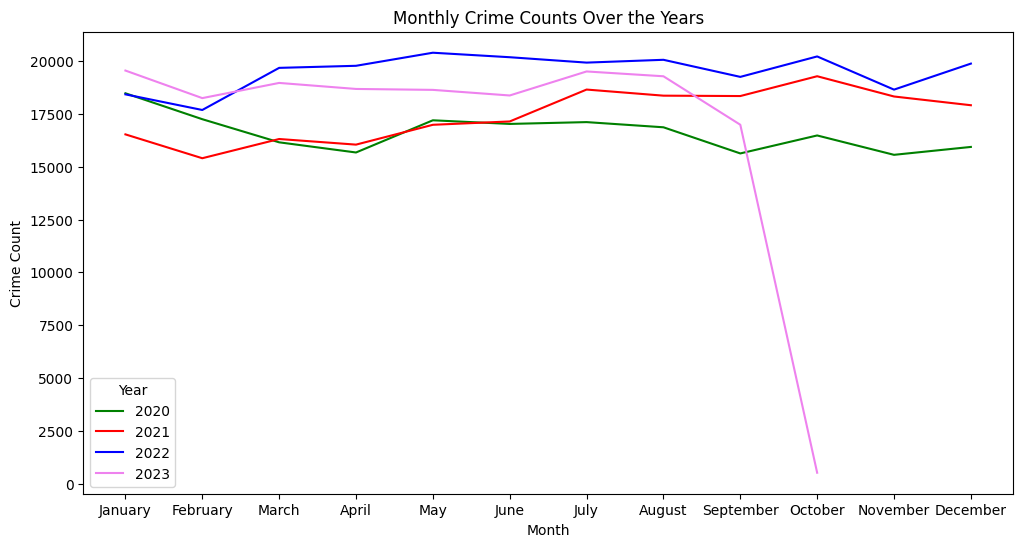

In [18]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 6))

ax = sns.lineplot(x="Month", y= 0, data=reset_df[reset_df['Year'] == 2020], color='green', label='2020')
ax = sns.lineplot(x="Month", y= 0, data=reset_df[reset_df['Year'] == 2021], color='red', label='2021')
ax = sns.lineplot(x="Month", y= 0, data=reset_df[reset_df['Year'] == 2022], color='blue', label='2022')
ax = sns.lineplot(x="Month", y= 0, data=reset_df[reset_df['Year'] == 2023], color='violet', label='2023')

plt.title('Monthly Crime Counts Over the Years')
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.legend(title='Year', loc='lower left')

#ax.set_xticklabels(month_order)

# ax.set_xticklabels(ax.get_xticklabels(), 
#                    fontsize = 13, 
#                    rotation = 30)

# Show the plot
plt.show()

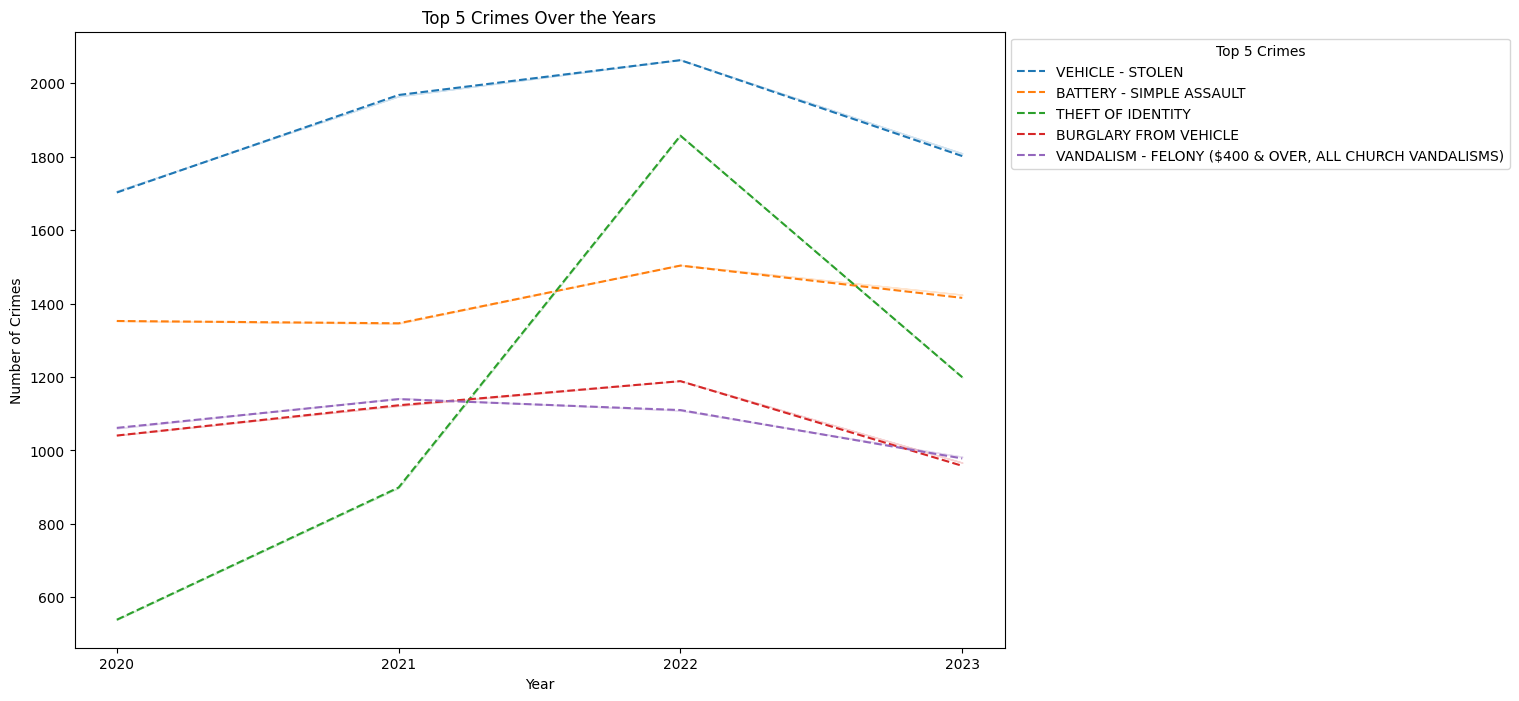

In [19]:
#Top 5 crimes over the years
top5_crimes = df['Crm Cd Desc'].value_counts().head(5).index.tolist()

df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
df['Month'] = df['Date Rptd'].dt.month
df['Year'] = df['Date Rptd'].dt.year

#Group the filtered data
crime_monthly_avg = df.groupby(['Crm Cd Desc', 'Year', 'Month']).size().reset_index(name='Count')

plt.figure(figsize=(12, 8))

for crime in top5_crimes:
    crime_data = crime_monthly_avg[crime_monthly_avg['Crm Cd Desc'] == crime]
    sns.lineplot(data=crime_data, x='Year', y='Count', linestyle='--', errorbar = ('ci', 0), label=crime)
    years = crime_data['Year'].astype(int)

plt.title('Top 5 Crimes Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.legend(title='Top 5 Crimes', loc='upper left', bbox_to_anchor=(1, 1))

# Customize the x-axis ticks
years = df['Year'].value_counts().index.tolist() 
plt.xticks(years, rotation = 0)

plt.show()

In [20]:
#crimes recorded per year
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])
df['Month'] = df['DATE OCC'].dt.month_name()
df['Year'] = df['DATE OCC'].dt.year
cpy = df.groupby('Year').size()
cpy_df = pd.DataFrame(cpy)
cpy_df

0
Year        
2020  199392
2021  209326
2022  234172
2023  168773

In [21]:
#Population data of LA
pop2020 = 9992236
pop2021 = 9811842
pop2022 = 9721138
pop2023 = 9500000

cpy_df['Population'] = [pop2020, pop2021, pop2022, pop2023]
cpy_df

0  Population
Year                    
2020  199392     9992236
2021  209326     9811842
2022  234172     9721138
2023  168773     9500000

In [22]:
cpy_df['crimerate'] = (cpy_df[0]/cpy_df['Population'])*1000000
cpy_df

0  Population     crimerate
Year                                  
2020  199392     9992236  19954.692824
2021  209326     9811842  21334.016589
2022  234172     9721138  24088.949257
2023  168773     9500000  17765.578947

In [23]:
#Calculating Crime rate per day per year
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])
crime_counts = df.groupby('DATE OCC').size()
cc_df = pd.DataFrame(crime_counts)

cc_df.index = pd.to_datetime(cc_df.index)
cc_df['Year'] = cc_df.index.year
cr_2020 = cc_df[cc_df['Year'] == 2020]
cr_2021 = cc_df[cc_df['Year'] == 2021]
cr_2022 = cc_df[cc_df['Year'] == 2022]
cr_2023 = cc_df[cc_df['Year'] == 2023]

cr_2020.loc[:, 'crimerate'] = (cr_2020[0] / pop2020) * 1000000
cr_2021.loc[:, 'crimerate'] = (cr_2021[0] / pop2021) * 1000000
cr_2022.loc[:, 'crimerate'] = (cr_2022[0] / pop2022) * 1000000
cr_2023.loc[:, 'crimerate'] = (cr_2023[0] / pop2023) * 1000000

cr_2020

C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\936474152.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cr_2020.loc[:, 'crimerate'] = (cr_2020[0] / pop2020) * 1000000
C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\936474152.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cr_2021.loc[:, 'crimerate'] = (cr_2021[0] / pop2021) * 1000000
C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\936474152.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

0  Year   crimerate
DATE OCC                          
2020-01-01  1103  2020  110.385703
2020-01-02   527  2020   52.740948
2020-01-03   595  2020   59.546232
2020-01-04   540  2020   54.041958
2020-01-05   505  2020   50.539239
...          ...   ...         ...
2020-12-27   448  2020   44.834810
2020-12-28   470  2020   47.036519
2020-12-29   458  2020   45.835587
2020-12-30   512  2020   51.239783
2020-12-31   573  2020   57.344522

[366 rows x 3 columns]

# 3. Most Common Crime Type:
Count the occurrences of each crime type and identify the one with the highest
frequency.

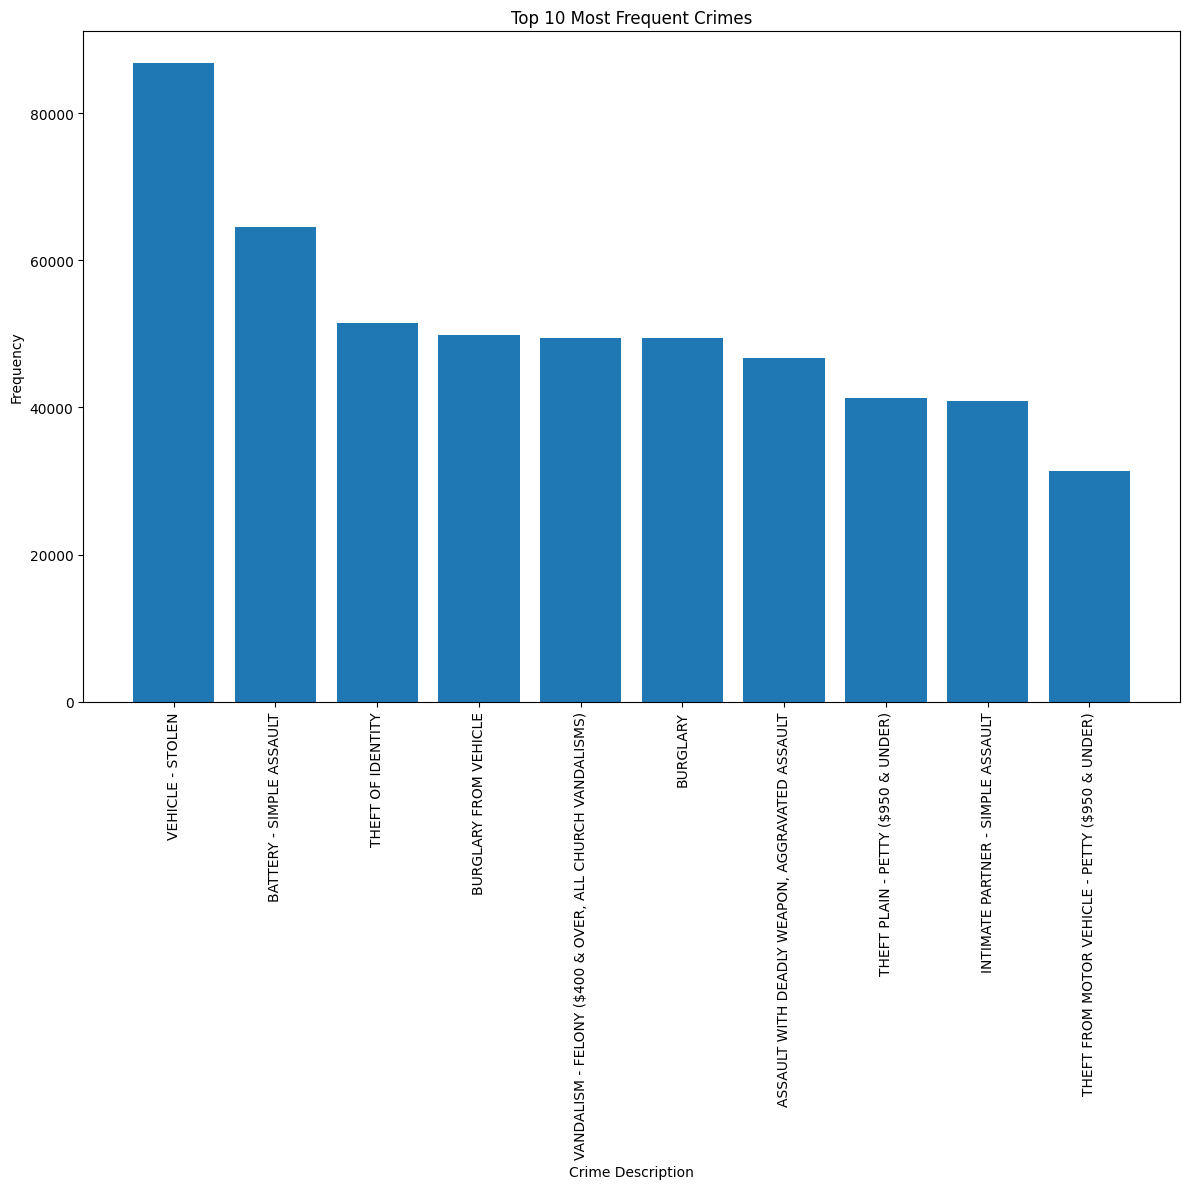

Frequencies of all crimes:
   Crm Cd                                        Crm Cd Desc  Count
0     510                                   VEHICLE - STOLEN  86816
1     624                           BATTERY - SIMPLE ASSAULT  64581
2     354                                  THEFT OF IDENTITY  51538
3     330                              BURGLARY FROM VEHICLE  49808
4     740  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  49514
5     310                                           BURGLARY  49423
6     230     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  46693
7     440                 THEFT PLAIN - PETTY ($950 & UNDER)  41290
8     626                  INTIMATE PARTNER - SIMPLE ASSAULT  40918
9     420    THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)  31356

-----------------------------------------------

The most common crime is with Crime Code: 510 
Description: VEHICLE - STOLEN
Frequency: 86816

-----------------------------------------------


In [24]:
crime_frequencies = df[['Crm Cd', 'Crm Cd Desc']].value_counts().reset_index()
crime_frequencies.columns = ['Crm Cd', 'Crm Cd Desc', 'Count']

most_common_crime = crime_frequencies.loc[crime_frequencies['Count'].idxmax()]

#bar graph 
top_10_crimes = crime_frequencies.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(12, 12))
plt.bar(top_10_crimes['Crm Cd Desc'], top_10_crimes['Count'])
plt.xlabel('Crime Description')
plt.xticks(rotation=90)  
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Crimes')
plt.tight_layout()

plt.show()

print("Frequencies of all crimes:")
print(crime_frequencies.head(10))
print("\n-----------------------------------------------")
print("\nThe most common crime is with Crime Code:", most_common_crime['Crm Cd'], "\nDescription:", most_common_crime['Crm Cd Desc'])
print("Frequency:", most_common_crime['Count'])
print("\n-----------------------------------------------")

# 4. Regional Differences:
 Group the data by region or city and compare crime rates between them using descriptive statistics or visualizations.

In [25]:
#!pip install geopandas

shapefile=gpd.read_file('LAPD/LAPD_Divisions.shp')
shapefile.head(10)

import numpy as np
area_df=df[['AREA NAME','DR_NO']]
print(np.sort(area_df['AREA NAME'].unique()))
np.sort(shapefile['APREC'].unique())

area_df.loc[area_df['AREA NAME']=='N Hollywood','AREA NAME']='North Hollywood'
area_df.loc[area_df['AREA NAME']=='West LA','AREA NAME']='West Los Angeles'
print(np.sort(area_df['AREA NAME'].unique()))

area_wise_df=pd.DataFrame(area_df['AREA NAME'].value_counts())
area_wise_df.reset_index(inplace=True)
area_wise_df['AREA NAME']=area_wise_df['AREA NAME'].str.upper()
area_wise_df
shapefile=pd.merge(left=shapefile,right=area_wise_df,left_on='APREC',right_on='AREA NAME',how='left')
shapefile.head(10)

['77th Street' 'Central' 'Devonshire' 'Foothill' 'Harbor' 'Hollenbeck'
 'Hollywood' 'Mission' 'N Hollywood' 'Newton' 'Northeast' 'Olympic'
 'Pacific' 'Rampart' 'Southeast' 'Southwest' 'Topanga' 'Van Nuys'
 'West LA' 'West Valley' 'Wilshire']
['77th Street' 'Central' 'Devonshire' 'Foothill' 'Harbor' 'Hollenbeck'
 'Hollywood' 'Mission' 'Newton' 'North Hollywood' 'Northeast' 'Olympic'
 'Pacific' 'Rampart' 'Southeast' 'Southwest' 'Topanga' 'Van Nuys'
 'West Los Angeles' 'West Valley' 'Wilshire']


OBJECTID             APREC  PREC          AREA      PERIMETER  SHAPE_Leng  \
0         1           MISSION    19  6.995826e+08  190817.495739    0.576177   
1         2        DEVONSHIRE    17  1.346816e+09  175591.702871    0.534007   
2         3          FOOTHILL    16  1.297385e+09  203717.879169    0.627755   
3         4           TOPANGA    21  9.090326e+08  155505.795458    0.470165   
4         5       WEST VALLEY    10  9.364057e+08  136316.899694    0.407795   
5         6   NORTH HOLLYWOOD    15  6.346011e+08  187366.252732    0.566582   
6         7          VAN NUYS     9  4.896950e+08  116288.308461    0.347249   
7         8         NORTHEAST    11  8.156022e+08  178460.722082    0.541347   
8         9         HOLLYWOOD     6  3.718353e+08  115808.747099    0.353721   
9        10  WEST LOS ANGELES     8  1.803659e+09  295206.415546    0.897951   

   SHAPE_Area                                           geometry  \
0    0.006363  POLYGON ((-118.50736 34.33464, -118.50381 34.3...   
1    0.012249  POLYGON ((-118.50736 34.33464, -118.50668 34.3...   
2    0.011797  POLYGON ((-118.41581 34.29384, -118.41567 34.2...   
3    0.008260  POLYGON ((-118.63166 34.23858, -118.63151 34.2...   
4    0.008507  POLYGON ((-118.56229 34.22035, -118.56184 34.2...   
5    0.005765  POLYGON ((-118.34264 34.11645, -118.34270 34.1...   
6    0.004449  POLYGON ((-118.47325 34.21651, -118.47313 34.2...   
7    0.007404  POLYGON ((-118.32904 34.15022, -118.32902 34.1...   
8    0.003375  POLYGON ((-118.34695 34.11831, -118.34694 34.1...   
9    0.016368  POLYGON ((-118.51758 34.02506, -118.51762 34.0...   

          AREA NAME  count  
0           MISSION  32310  
1        DEVONSHIRE  32936  
2          FOOTHILL  27106  
3           TOPANGA  32945  
4       WEST VALLEY  33997  
5   NORTH HOLLYWOOD  40340  
6          VAN NUYS  34454  
7         NORTHEAST  35058  
8         HOLLYWOOD  43046  
9  WEST LOS ANGELES  37255

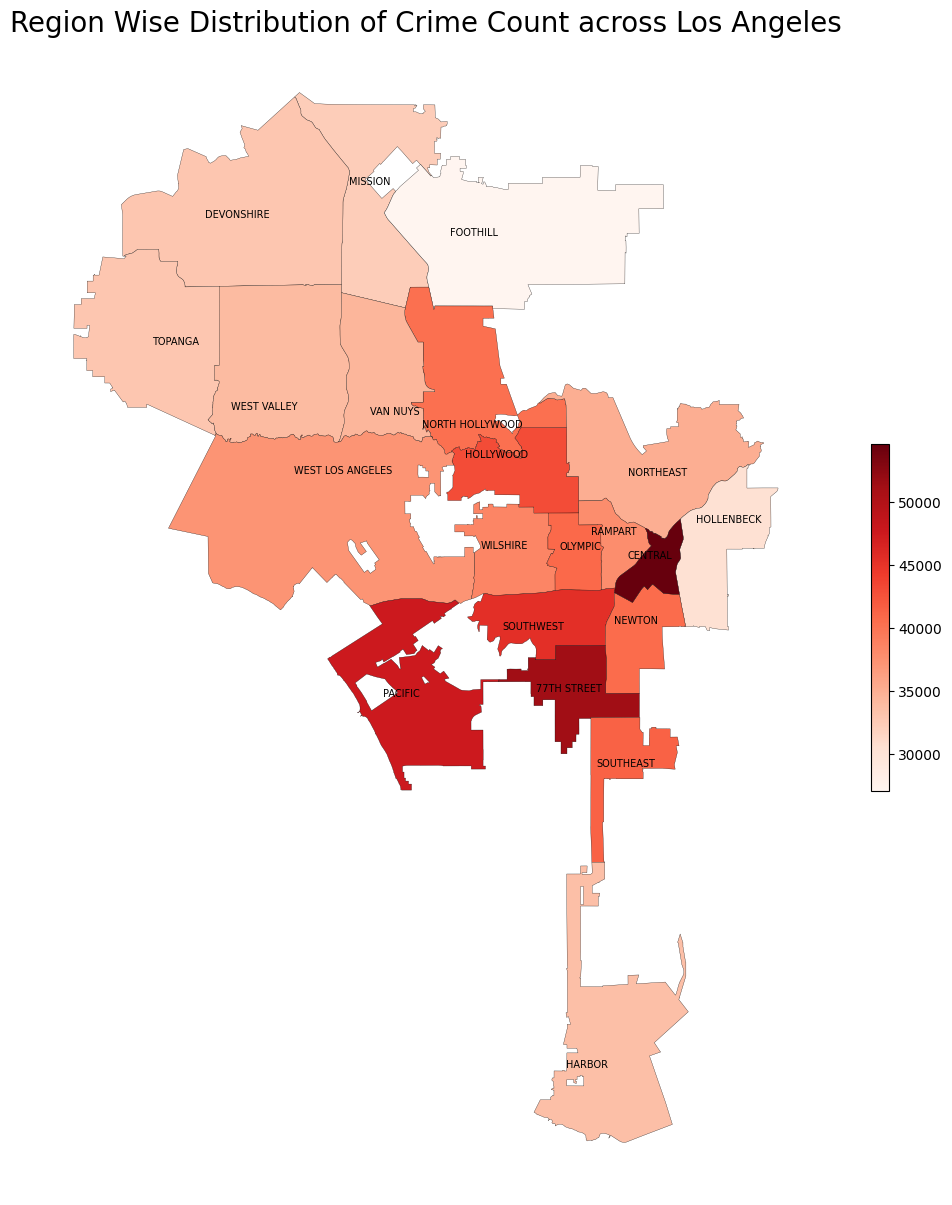

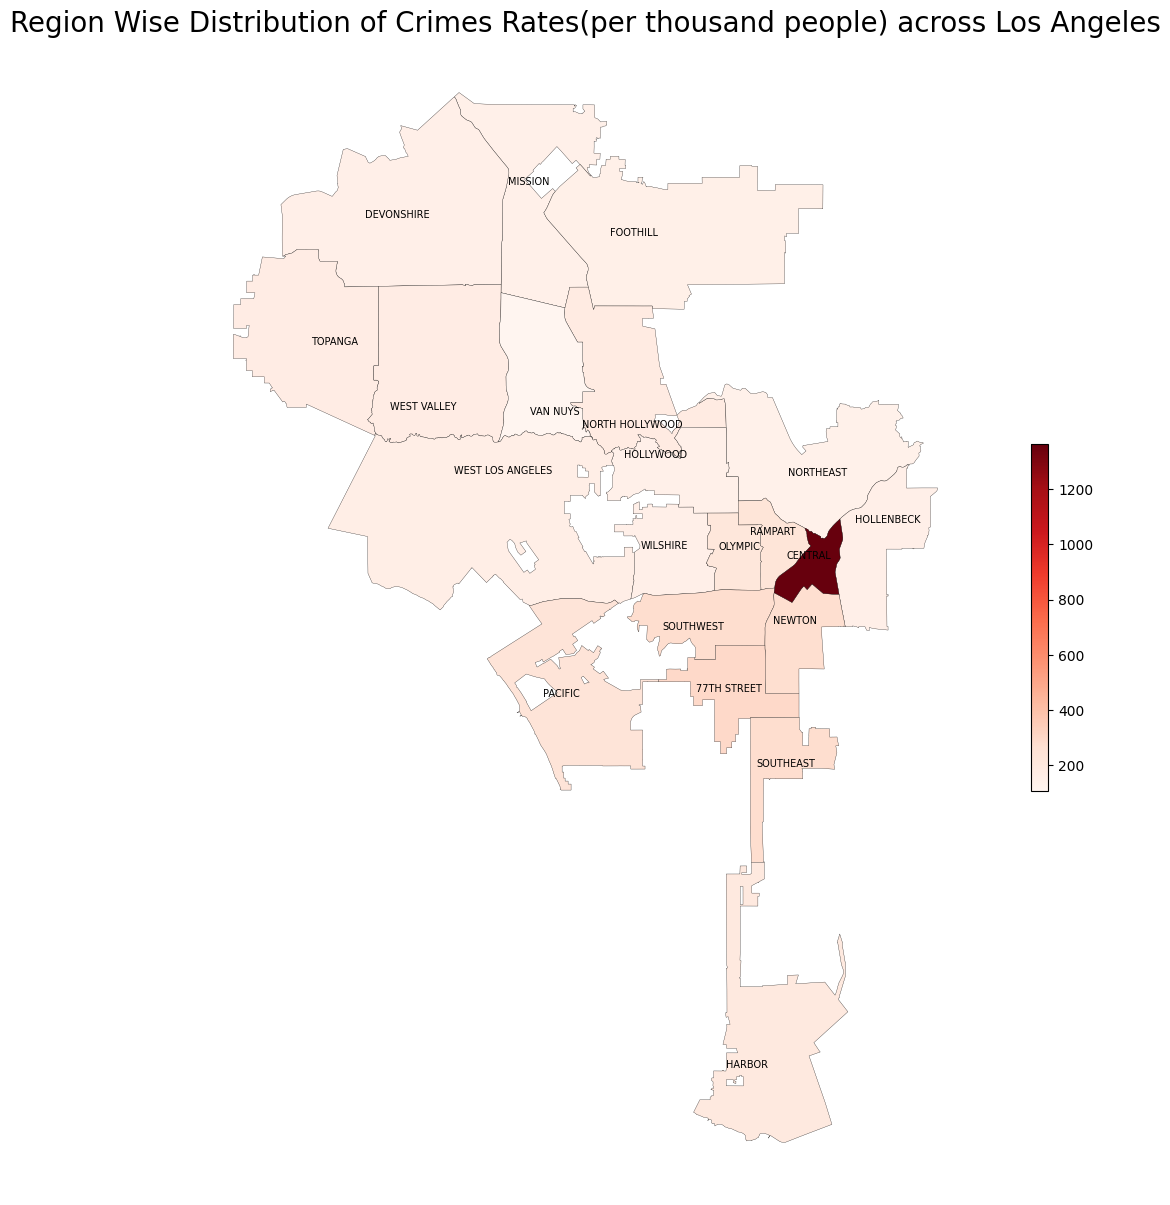

In [26]:
fig,ax=plt.subplots(figsize=(15,15))
shapefile.plot(ax=ax,column='count',cmap='Reds',legend=True,legend_kwds={'shrink':0.3},edgecolor='black',linewidth=0.2)

for elt in shapefile['APREC'].unique():
    coord=shapefile[shapefile['APREC']==elt].geometry.get_coordinates()
    ax.annotate(elt,(coord.x.mean(),coord.y.mean()),ha='center',fontsize=7)
ax.axis("off")
plt.title("Region Wise Distribution of Crime Count across Los Angeles",fontsize=20)
plt.show()

population={'APREC':['VAN NUYS','NORTH HOLLYWOOD','77TH STREET','CENTRAL','DEVONSHIRE','FOOTHILL','HARBOR','HOLLENBECK','HOLLYWOOD','MISSION','NEWTON','NORTHEAST','OLYMPIC','PACIFIC','RAMPART','SOUTHEAST','SOUTHWEST','TOPANGA','WEST LOS ANGELES','WEST VALLEY','WILSHIRE'],
            'POPULATION':[325000,220000,175000,40000,219136,182214,171000,200000,300000,225849,150000,250000,0,200000,164961,150000,165000,193172,228000,196840,251000]}
pop_df=pd.DataFrame(population)
pop_df.loc[pop_df['APREC']=='OLYMPIC','POPULATION']=int(pop_df['POPULATION'].mean())
pop_df

shapefile=pd.merge(left=shapefile,right=pop_df,on='APREC',how='left')
shapefile.head(10)

shapefile['crime rate per thousand']=(shapefile['count']/shapefile['POPULATION'])*1000
shapefile['crime rate']=(shapefile['count']/shapefile['POPULATION'])
shapefile

from matplotlib.colors import ListedColormap
fig,ax=plt.subplots(figsize=(15,15))
shapefile.plot(ax=ax,column='crime rate per thousand',cmap='Reds',legend=True,legend_kwds={'shrink':0.3},edgecolor='black',linewidth=0.2)

for elt in shapefile['APREC'].unique():
    coord=shapefile[shapefile['APREC']==elt].geometry.get_coordinates()
    ax.annotate(elt,(coord.x.mean(),coord.y.mean()),ha='center',fontsize=7)
ax.axis("off")
plt.title("Region Wise Distribution of Crimes Rates(per thousand people) across Los Angeles",fontsize=20)
plt.show()

# 5. Correlation with Economic Factors:
 Collect economic data for the same time frame and use statistical methods like correlation analysis to assess the relationship between economic factors and crime rates.

In [27]:
precinct_df=pd.read_excel("precinct.xlsx")
STREET_df = pd.DataFrame()
STREET_df['name']=precinct_df['77TH STREET'].dropna()
STREET_df

unemploy_df=pd.read_excel("Unemployment Rate - 2021.xlsx")
names=list(unemploy_df['name'].unique())
names.sort()
names

STREET_df=pd.merge(left=STREET_df,right=unemploy_df,on='name',how='left')
STREET_df.dropna
STREET_df

STREET_df.dropna(inplace=True)
STREET_df

population_df=pd.read_excel("Total Population - 2021.xlsx")
population_df

STREET_df=pd.merge(left=STREET_df,right=population_df,on='name',how='left')
STREET_df

STREET_df.dtypes
STREET_df['Unemployment Rate'] = STREET_df['Unemployment Rate'].astype(str).str.rstrip('%').astype(float)
STREET_df

area_unemployment_rate_df =pd.DataFrame()
area_unemployment_rate_df['APREC']=precinct_df.keys()
for k in list(precinct_df.keys()):
    neighbourhood_df = pd.DataFrame()
    neighbourhood_df['name']=precinct_df[k].dropna()
    neighbourhood_df=pd.merge(left=neighbourhood_df,right=unemploy_df,on='name',how='left')
    neighbourhood_df.dropna(inplace=True)
    neighbourhood_df['Unemployment Rate'] = neighbourhood_df['Unemployment Rate'].astype(str).str.rstrip('%').astype(float)
    neighbourhood_df=pd.merge(left=neighbourhood_df,right=population_df,on='name',how='left')
    weighted_avg_unemployement_rate=round(sum(neighbourhood_df['Unemployment Rate']*neighbourhood_df['total_pop'])/sum(neighbourhood_df['total_pop']),2)
    area_unemployment_rate_df.loc[area_unemployment_rate_df['APREC']==k,'Unemployment Rate']=weighted_avg_unemployement_rate
print(area_unemployment_rate_df)
print(area_unemployment_rate_df.shape)
print(area_unemployment_rate_df.columns)

               APREC  Unemployment Rate
0        77TH STREET               9.08
1            CENTRAL               9.67
2         DEVONSHIRE               6.36
3           FOOTHILL               6.94
4             HARBOR               7.19
5         HOLLENBECK               8.58
6          HOLLYWOOD               8.51
7            MISSION               7.10
8             NEWTON               8.34
9    NORTH HOLLYWOOD               7.79
10         NORTHEAST               7.94
11           OLYMPIC               6.18
12           PACIFIC               5.74
13           RAMPART               6.90
14         SOUTHEAST              10.62
15         SOUTHWEST              10.10
16           TOPANGA               7.91
17          VAN NUYS               7.56
18  WEST LOS ANGELES               6.78
19       WEST VALLEY               6.85
20          WILSHIRE               7.76
(21, 2)
Index(['APREC', 'Unemployment Rate'], dtype='object')


In [28]:
df.head(10)

DR_NO  Date Rptd   DATE OCC  TIME OCC  AREA    AREA NAME  Rpt Dist No  \
0   10304468 2020-01-08 2020-01-08  22:30:00     3    Southwest          377   
1  190101086 2020-01-02 2020-01-01  03:30:00     1      Central          163   
2  200110444 2020-04-14 2020-02-13  12:00:00     1      Central          155   
3  191501505 2020-01-01 2020-01-01  17:30:00    15  N Hollywood         1543   
4  191921269 2020-01-01 2020-01-01  04:15:00    19      Mission         1998   
5  200100501 2020-01-02 2020-01-01  00:30:00     1      Central          163   
6  200100502 2020-01-02 2020-01-02  13:15:00     1      Central          161   
7  200100504 2020-01-04 2020-01-04  00:40:00     1      Central          155   
8  200100507 2020-01-04 2020-01-04  02:00:00     1      Central          101   
9  201710201 2020-06-19 2020-05-26  19:25:00    17   Devonshire         1708   

   Part 1-2  Crm Cd                                        Crm Cd Desc  ...  \
0         2     624                           BATTERY - SIMPLE ASSAULT  ...   
1         2     624                           BATTERY - SIMPLE ASSAULT  ...   
2         2     845          SEX OFFENDER REGISTRANT OUT OF COMPLIANCE  ...   
3         2     745           VANDALISM - MISDEAMEANOR ($399 OR UNDER)  ...   
4         2     740  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  ...   
5         1     121                                     RAPE, FORCIBLE  ...   
6         1     442           SHOPLIFTING - PETTY THEFT ($950 & UNDER)  ...   
7         2     946                          OTHER MISCELLANEOUS CRIME  ...   
8         1     341  THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...  ...   
9         1     341  THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...  ...   

  Crm Cd 1  Crm Cd 2 Crm Cd 3 Crm Cd 4  \
0    624.0       NaN      NaN      NaN   
1    624.0       NaN      NaN      NaN   
2    845.0       NaN      NaN      NaN   
3    745.0     998.0      NaN      NaN   
4    740.0       NaN      NaN      NaN   
5    121.0     998.0      NaN      NaN   
6    442.0     998.0      NaN      NaN   
7    946.0     998.0      NaN      NaN   
8    341.0     998.0      NaN      NaN   
9    341.0       NaN      NaN      NaN   

                                   LOCATION Cross Street      LAT       LON  \
0   1100 W  39TH                         PL          NaN  34.0141 -118.2978   
1    700 S  HILL                         ST          NaN  34.0459 -118.2545   
2    200 E  6TH                          ST          NaN  34.0448 -118.2474   
3   5400    CORTEEN                      PL          NaN  34.1685 -118.4019   
4  14400    TITUS                        ST          NaN  34.2198 -118.4468   
5                           700 S  BROADWAY          NaN  34.0452 -118.2534   
6    700 S  FIGUEROA                     ST          NaN  34.0483 -118.2631   
7    200 E  6TH                          ST          NaN  34.0448 -118.2474   
8    700    BERNARD                      ST          NaN  34.0677 -118.2398   
9  11900    BALBOA                       BL          NaN  34.2864 -118.5021   

   Year     Month  
0  2020   January  
1  2020   January  
2  2020  February  
3  2020   January  
4  2020   January  
5  2020   January  
6  2020   January  
7  2020   January  
8  2020   January  
9  2020       May  

[10 rows x 30 columns]

In [29]:
# Convert the column to a datetime data type if it's not already
# df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
# df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %H:%M')
# df['TIME OCC'] = df['TIME OCC'].astype(str).str.zfill(4)
# df['TIME OCC'] = pd.to_datetime(df['TIME OCC'], format='%H%M').dt.time

df.head(10)

DR_NO  Date Rptd   DATE OCC  TIME OCC  AREA    AREA NAME  Rpt Dist No  \
0   10304468 2020-01-08 2020-01-08  22:30:00     3    Southwest          377   
1  190101086 2020-01-02 2020-01-01  03:30:00     1      Central          163   
2  200110444 2020-04-14 2020-02-13  12:00:00     1      Central          155   
3  191501505 2020-01-01 2020-01-01  17:30:00    15  N Hollywood         1543   
4  191921269 2020-01-01 2020-01-01  04:15:00    19      Mission         1998   
5  200100501 2020-01-02 2020-01-01  00:30:00     1      Central          163   
6  200100502 2020-01-02 2020-01-02  13:15:00     1      Central          161   
7  200100504 2020-01-04 2020-01-04  00:40:00     1      Central          155   
8  200100507 2020-01-04 2020-01-04  02:00:00     1      Central          101   
9  201710201 2020-06-19 2020-05-26  19:25:00    17   Devonshire         1708   

   Part 1-2  Crm Cd                                        Crm Cd Desc  ...  \
0         2     624                           BATTERY - SIMPLE ASSAULT  ...   
1         2     624                           BATTERY - SIMPLE ASSAULT  ...   
2         2     845          SEX OFFENDER REGISTRANT OUT OF COMPLIANCE  ...   
3         2     745           VANDALISM - MISDEAMEANOR ($399 OR UNDER)  ...   
4         2     740  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  ...   
5         1     121                                     RAPE, FORCIBLE  ...   
6         1     442           SHOPLIFTING - PETTY THEFT ($950 & UNDER)  ...   
7         2     946                          OTHER MISCELLANEOUS CRIME  ...   
8         1     341  THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...  ...   
9         1     341  THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...  ...   

  Crm Cd 1  Crm Cd 2 Crm Cd 3 Crm Cd 4  \
0    624.0       NaN      NaN      NaN   
1    624.0       NaN      NaN      NaN   
2    845.0       NaN      NaN      NaN   
3    745.0     998.0      NaN      NaN   
4    740.0       NaN      NaN      NaN   
5    121.0     998.0      NaN      NaN   
6    442.0     998.0      NaN      NaN   
7    946.0     998.0      NaN      NaN   
8    341.0     998.0      NaN      NaN   
9    341.0       NaN      NaN      NaN   

                                   LOCATION Cross Street      LAT       LON  \
0   1100 W  39TH                         PL          NaN  34.0141 -118.2978   
1    700 S  HILL                         ST          NaN  34.0459 -118.2545   
2    200 E  6TH                          ST          NaN  34.0448 -118.2474   
3   5400    CORTEEN                      PL          NaN  34.1685 -118.4019   
4  14400    TITUS                        ST          NaN  34.2198 -118.4468   
5                           700 S  BROADWAY          NaN  34.0452 -118.2534   
6    700 S  FIGUEROA                     ST          NaN  34.0483 -118.2631   
7    200 E  6TH                          ST          NaN  34.0448 -118.2474   
8    700    BERNARD                      ST          NaN  34.0677 -118.2398   
9  11900    BALBOA                       BL          NaN  34.2864 -118.5021   

   Year     Month  
0  2020   January  
1  2020   January  
2  2020  February  
3  2020   January  
4  2020   January  
5  2020   January  
6  2020   January  
7  2020   January  
8  2020   January  
9  2020       May  

[10 rows x 30 columns]

In [30]:
df.loc[df['AREA NAME']=='N Hollywood','AREA NAME']='North Hollywood'
df.loc[df['AREA NAME']=='West LA','AREA NAME']='West Los Angeles'

area_date_df=df[['AREA NAME','DATE OCC']]
area_date_df = area_date_df.assign(year=area_date_df['DATE OCC'].dt.year)
area_date_df

area_crime_year = area_date_df.groupby(['year', 'AREA NAME']).size().reset_index(name='Count2021')
area_crime_2021=area_crime_year[area_crime_year['year']==2021]
area_crime_2021

area_crime_2021.loc[:, 'AREA NAME'] = area_crime_2021['AREA NAME'].str.upper()
area_crime_2021

# shapefile=pd.merge(left=shapefile,right=area_crime_2021[['AREA NAME','Count2021']],on='AREA NAME',how='left')
# shapefile.head(10)

shapefile = pd.merge(left=shapefile, right=area_crime_2021[['AREA NAME', 'Count2021']], on='AREA NAME', how='left', suffixes=('_left', '_right'))
# shapefile.head(10)


In [31]:
#shapefile.drop(columns=['Count2021_x','Count2021_y','Count2021'],inplace=True)

shapefile['crime rate per thousand in 2021']=round((shapefile['Count2021']/shapefile['POPULATION'])*1000,2)
shapefile['crime rate in 2021']=round(shapefile['Count2021']/shapefile['POPULATION'],2)
shapefile

OBJECTID             APREC  PREC          AREA      PERIMETER  SHAPE_Leng  \
0          1           MISSION    19  6.995826e+08  190817.495739    0.576177   
1          2        DEVONSHIRE    17  1.346816e+09  175591.702871    0.534007   
2          3          FOOTHILL    16  1.297385e+09  203717.879169    0.627755   
3          4           TOPANGA    21  9.090326e+08  155505.795458    0.470165   
4          5       WEST VALLEY    10  9.364057e+08  136316.899694    0.407795   
5          6   NORTH HOLLYWOOD    15  6.346011e+08  187366.252732    0.566582   
6          7          VAN NUYS     9  4.896950e+08  116288.308461    0.347249   
7          8         NORTHEAST    11  8.156022e+08  178460.722082    0.541347   
8          9         HOLLYWOOD     6  3.718353e+08  115808.747099    0.353721   
9         10  WEST LOS ANGELES     8  1.803659e+09  295206.415546    0.897951   
10        11        HOLLENBECK     4  4.330323e+08  111317.952873    0.329096   
11        12           RAMPART     2  1.543954e+08   63585.309548    0.190796   
12        13          WILSHIRE     7  3.270671e+08  100948.314557    0.307986   
13        14           OLYMPIC    20  1.744185e+08   62023.560255    0.186738   
14        15         SOUTHWEST     3  3.433255e+08  102632.208443    0.316321   
15        16            NEWTON    13  2.723760e+08   81476.922847    0.241128   
16        17           PACIFIC    14  7.176129e+08  246934.321606    0.757182   
17        18       77TH STREET    12  3.159590e+08  114137.816270    0.347916   
18        19         SOUTHEAST    18  2.611391e+08  111470.973394    0.327828   
19        20            HARBOR     5  8.928780e+08  272451.139908    0.807721   
20        21           CENTRAL     1  1.367477e+08   64187.406589    0.190474   

    SHAPE_Area                                           geometry  \
0     0.006363  POLYGON ((-118.50736 34.33464, -118.50381 34.3...   
1     0.012249  POLYGON ((-118.50736 34.33464, -118.50668 34.3...   
2     0.011797  POLYGON ((-118.41581 34.29384, -118.41567 34.2...   
3     0.008260  POLYGON ((-118.63166 34.23858, -118.63151 34.2...   
4     0.008507  POLYGON ((-118.56229 34.22035, -118.56184 34.2...   
5     0.005765  POLYGON ((-118.34264 34.11645, -118.34270 34.1...   
6     0.004449  POLYGON ((-118.47325 34.21651, -118.47313 34.2...   
7     0.007404  POLYGON ((-118.32904 34.15022, -118.32902 34.1...   
8     0.003375  POLYGON ((-118.34695 34.11831, -118.34694 34.1...   
9     0.016368  POLYGON ((-118.51758 34.02506, -118.51762 34.0...   
10    0.003929  POLYGON ((-118.22649 34.07991, -118.22616 34.0...   
11    0.001401  POLYGON ((-118.30049 34.09084, -118.29952 34.0...   
12    0.002967  POLYGON ((-118.37617 34.05961, -118.37602 34.0...   
13    0.001582  POLYGON ((-118.32271 34.08351, -118.32226 34.0...   
14    0.003113  POLYGON ((-118.28402 34.03713, -118.28401 34.0...   
15    0.002470  POLYGON ((-118.28107 34.00379, -118.28106 34.0...   
16    0.006504  POLYGON ((-118.42224 33.91633, -118.42757 33.9...   
17    0.002864  POLYGON ((-118.33218 33.99633, -118.33220 33.9...   
18    0.002366  POLYGON ((-118.29168 33.95950, -118.29168 33.9...   
19    0.008072  POLYGON ((-118.26739 33.70366, -118.26745 33.7...   
20    0.001240  POLYGON ((-118.25196 34.07419, -118.25188 34.0...   

           AREA NAME  count  POPULATION  crime rate per thousand  crime rate  \
0            MISSION  32310      225849               143.060186    0.143060   
1         DEVONSHIRE  32936      219136               150.299357    0.150299   
2           FOOTHILL  27106      182214               148.759151    0.148759   
3            TOPANGA  32945      193172               170.547491    0.170547   
4        WEST VALLEY  33997      196840               172.713879    0.172714   
5    NORTH HOLLYWOOD  40340      220000               183.363636    0.183364   
6           VAN NUYS  34454      325000               106.012308    0.106012   
7          NORTHEAST  35058      250000               140.2320

In [32]:
shapefile=pd.merge(left=shapefile,right=area_unemployment_rate_df,on='APREC',how='left')
shapefile.head()

OBJECTID        APREC  PREC          AREA      PERIMETER  SHAPE_Leng  \
0         1      MISSION    19  6.995826e+08  190817.495739    0.576177   
1         2   DEVONSHIRE    17  1.346816e+09  175591.702871    0.534007   
2         3     FOOTHILL    16  1.297385e+09  203717.879169    0.627755   
3         4      TOPANGA    21  9.090326e+08  155505.795458    0.470165   
4         5  WEST VALLEY    10  9.364057e+08  136316.899694    0.407795   

   SHAPE_Area                                           geometry    AREA NAME  \
0    0.006363  POLYGON ((-118.50736 34.33464, -118.50381 34.3...      MISSION   
1    0.012249  POLYGON ((-118.50736 34.33464, -118.50668 34.3...   DEVONSHIRE   
2    0.011797  POLYGON ((-118.41581 34.29384, -118.41567 34.2...     FOOTHILL   
3    0.008260  POLYGON ((-118.63166 34.23858, -118.63151 34.2...      TOPANGA   
4    0.008507  POLYGON ((-118.56229 34.22035, -118.56184 34.2...  WEST VALLEY   

   count  POPULATION  crime rate per thousand  crime rate  Count2021  \
0  32310      225849               143.060186    0.143060       8211   
1  32936      219136               150.299357    0.150299       8481   
2  27106      182214               148.759151    0.148759       7026   
3  32945      193172               170.547491    0.170547       8568   
4  33997      196840               172.713879    0.172714       8518   

   crime rate per thousand in 2021  crime rate in 2021  Unemployment Rate  
0                            36.36                0.04               7.10  
1                            38.70                0.04               6.36  
2                            38.56                0.04               6.94  
3                            44.35                0.04               7.91  
4                            43.27                0.04               6.85

In [33]:
median_income_df=pd.read_excel("Median Household Income - 2021.xlsx")
median_income_df

name  year  denom_total_hh  Median Household Income
0                  Irwindale  2021          476.37                 95123.29
1                 Pico-Union  2021        11369.83                 43400.06
2                   Glendora  2021        16820.69                102958.65
3                   Industry  2021         3404.85                 90371.92
4                     Sylmar  2021        21199.50                 84217.00
..                       ...   ...             ...                      ...
253               El Segundo  2021         7062.17                123500.75
254  View Park-Windsor Hills  2021         4847.29                 98325.04
255             Sierra Madre  2021         4955.79                108847.86
256            Gramercy Park  2021         4044.34                 74471.22
257               Aggregated  2021      3324087.75                 83707.31

[258 rows x 4 columns]

In [34]:
area_median_income_df =pd.DataFrame()
area_median_income_df['APREC']=precinct_df.keys()
for k in list(precinct_df.keys()):
    neighbourhood_df = pd.DataFrame()
    neighbourhood_df['name']=precinct_df[k].dropna()
    neighbourhood_df=pd.merge(left=neighbourhood_df,right=median_income_df,on='name',how='left')
    neighbourhood_df.dropna(inplace=True)
    area_median_income_df.loc[area_median_income_df['APREC']==k,'Median Household Income']=neighbourhood_df['Median Household Income'].median()
print(area_median_income_df)
print(area_median_income_df.shape)
print(area_median_income_df.columns)

shapefile=pd.merge(left=shapefile,right=area_median_income_df,on='APREC',how='left')
shapefile

               APREC  Median Household Income
0        77TH STREET                53829.960
1            CENTRAL                46529.930
2         DEVONSHIRE               110520.440
3           FOOTHILL                77984.865
4             HARBOR                71530.820
5         HOLLENBECK                58773.170
6          HOLLYWOOD                77232.670
7            MISSION                82290.900
8             NEWTON                47360.190
9    NORTH HOLLYWOOD                73778.465
10         NORTHEAST                79212.680
11           OLYMPIC                47307.735
12           PACIFIC               107191.360
13           RAMPART                45487.480
14         SOUTHEAST                53142.230
15         SOUTHWEST                52025.710
16           TOPANGA                94076.080
17          VAN NUYS                64516.100
18  WEST LOS ANGELES               154584.570
19       WEST VALLEY                84646.990
20          WILSHIRE              

OBJECTID             APREC  PREC          AREA      PERIMETER  SHAPE_Leng  \
0          1           MISSION    19  6.995826e+08  190817.495739    0.576177   
1          2        DEVONSHIRE    17  1.346816e+09  175591.702871    0.534007   
2          3          FOOTHILL    16  1.297385e+09  203717.879169    0.627755   
3          4           TOPANGA    21  9.090326e+08  155505.795458    0.470165   
4          5       WEST VALLEY    10  9.364057e+08  136316.899694    0.407795   
5          6   NORTH HOLLYWOOD    15  6.346011e+08  187366.252732    0.566582   
6          7          VAN NUYS     9  4.896950e+08  116288.308461    0.347249   
7          8         NORTHEAST    11  8.156022e+08  178460.722082    0.541347   
8          9         HOLLYWOOD     6  3.718353e+08  115808.747099    0.353721   
9         10  WEST LOS ANGELES     8  1.803659e+09  295206.415546    0.897951   
10        11        HOLLENBECK     4  4.330323e+08  111317.952873    0.329096   
11        12           RAMPART     2  1.543954e+08   63585.309548    0.190796   
12        13          WILSHIRE     7  3.270671e+08  100948.314557    0.307986   
13        14           OLYMPIC    20  1.744185e+08   62023.560255    0.186738   
14        15         SOUTHWEST     3  3.433255e+08  102632.208443    0.316321   
15        16            NEWTON    13  2.723760e+08   81476.922847    0.241128   
16        17           PACIFIC    14  7.176129e+08  246934.321606    0.757182   
17        18       77TH STREET    12  3.159590e+08  114137.816270    0.347916   
18        19         SOUTHEAST    18  2.611391e+08  111470.973394    0.327828   
19        20            HARBOR     5  8.928780e+08  272451.139908    0.807721   
20        21           CENTRAL     1  1.367477e+08   64187.406589    0.190474   

    SHAPE_Area                                           geometry  \
0     0.006363  POLYGON ((-118.50736 34.33464, -118.50381 34.3...   
1     0.012249  POLYGON ((-118.50736 34.33464, -118.50668 34.3...   
2     0.011797  POLYGON ((-118.41581 34.29384, -118.41567 34.2...   
3     0.008260  POLYGON ((-118.63166 34.23858, -118.63151 34.2...   
4     0.008507  POLYGON ((-118.56229 34.22035, -118.56184 34.2...   
5     0.005765  POLYGON ((-118.34264 34.11645, -118.34270 34.1...   
6     0.004449  POLYGON ((-118.47325 34.21651, -118.47313 34.2...   
7     0.007404  POLYGON ((-118.32904 34.15022, -118.32902 34.1...   
8     0.003375  POLYGON ((-118.34695 34.11831, -118.34694 34.1...   
9     0.016368  POLYGON ((-118.51758 34.02506, -118.51762 34.0...   
10    0.003929  POLYGON ((-118.22649 34.07991, -118.22616 34.0...   
11    0.001401  POLYGON ((-118.30049 34.09084, -118.29952 34.0...   
12    0.002967  POLYGON ((-118.37617 34.05961, -118.37602 34.0...   
13    0.001582  POLYGON ((-118.32271 34.08351, -118.32226 34.0...   
14    0.003113  POLYGON ((-118.28402 34.03713, -118.28401 34.0...   
15    0.002470  POLYGON ((-118.28107 34.00379, -118.28106 34.0...   
16    0.006504  POLYGON ((-118.42224 33.91633, -118.42757 33.9...   
17    0.002864  POLYGON ((-118.33218 33.99633, -118.33220 33.9...   
18    0.002366  POLYGON ((-118.29168 33.95950, -118.29168 33.9...   
19    0.008072  POLYGON ((-118.26739 33.70366, -118.26745 33.7...   
20    0.001240  POLYGON ((-118.25196 34.07419, -118.25188 34.0...   

           AREA NAME  count  POPULATION  crime rate per thousand  crime rate  \
0            MISSION  32310      225849               143.060186    0.143060   
1         DEVONSHIRE  32936      219136               150.299357    0.150299   
2           FOOTHILL  27106      182214               148.759151    0.148759   
3            TOPANGA  32945      193172               170.547491    0.170547   
4        WEST VALLEY  33997      196840               172.713879    0.172714   
5    NORTH HOLLYWOOD  40340      220000               183.363636    0.183364   
6           VAN NUYS  34454      325000               106.012308    0.106012   
7          NORTHEAST  35058      250000               140.2320

In [35]:
from statistics import mean
import folium
state_geo_subset=shapefile[['APREC','Unemployment Rate','geometry','crime rate per thousand in 2021','Median Household Income']]
state_geo_subset.columns=['APREC','Unemployment Rate','geometry','crimerate','Median Household Income']
m=state_geo_subset.explore(column='Unemployment Rate',name='Unemployment Rate (Percentage) in 2021',cmap="Blues")
state_geo_subset.explore(m=m,column='Median Household Income',name='Median Household Income in 2021',cmap="Greens")
for city in state_geo_subset.itertuples():
    lat_list=[]
    long_list=[]
    for long,lat in city.geometry.exterior.coords:
        lat_list.append(lat)
        long_list.append(long)
    folium.CircleMarker(
            location=[mean(lat_list), mean(long_list)],
            popup='%s Crime Rate in 2021:(%.1f)' % (city.APREC,city.crimerate),
            radius=(city.crimerate)/7,
            color='crimson',
            fill=True,
            fill_color='crimson'
       ).add_to(m)

item_txt = """&nbsp; {item} &nbsp; <i class="fa-regular fa-circle" style="color:{col}"></i>"""
html_itms = item_txt.format( item= "Crime Rate" , col= "red")

legend_html = """
     <div style="
     position: fixed;
     bottom: 50px; left: 50px; width: 125px; height: 26px;
     border:2px solid grey; z-index:9999;

     background-color:white;
     opacity: .85;

     font-size:15px;
     font-weight: bold;

     ">
     {itm_txt}
     </div> """.format(itm_txt= html_itms)

m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl().add_to(m)
m

<Axes: >

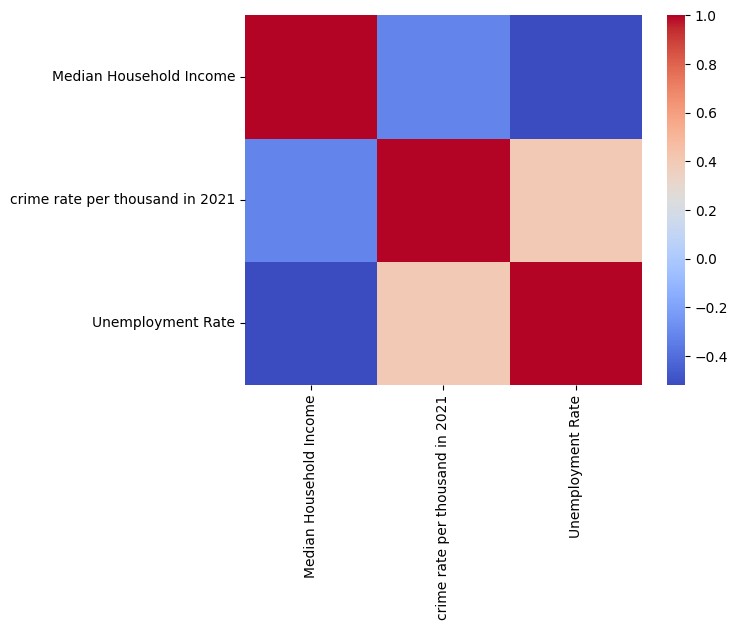

In [36]:
correlation_matrix=shapefile[['Median Household Income','crime rate per thousand in 2021','Unemployment Rate']].corr()
correlation_matrix

sns.heatmap(correlation_matrix,cmap='coolwarm')

<Axes: xlabel='Median Household Income', ylabel='crime rate per thousand in 2021'>

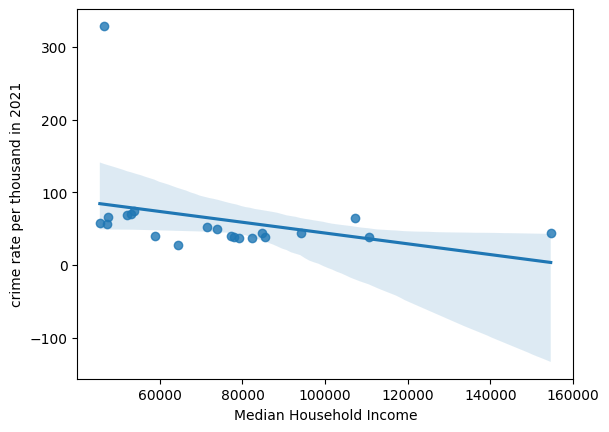

In [37]:
sns.regplot(x='Median Household Income',y='crime rate per thousand in 2021',data=shapefile)

<Axes: xlabel='Unemployment Rate', ylabel='crime rate per thousand in 2021'>

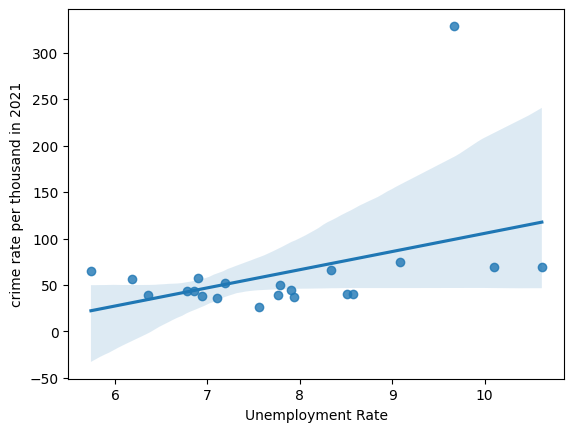

In [38]:
sns.regplot(x='Unemployment Rate',y='crime rate per thousand in 2021',data=shapefile)

# 6. Day of the Week Analysis:
Group the data by day of the week and analyze crime frequencies for each day.

In [39]:
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

df['Day_of_Week'] = df['DATE OCC'].dt.day_name()

crime_freq_by_day = df['Day_of_Week'].value_counts().sort_index()

print(crime_freq_by_day)


Day_of_Week
Friday       123818
Monday       114967
Saturday     118609
Sunday       113175
Thursday     114540
Tuesday      111265
Wednesday    115289
Name: count, dtype: int64


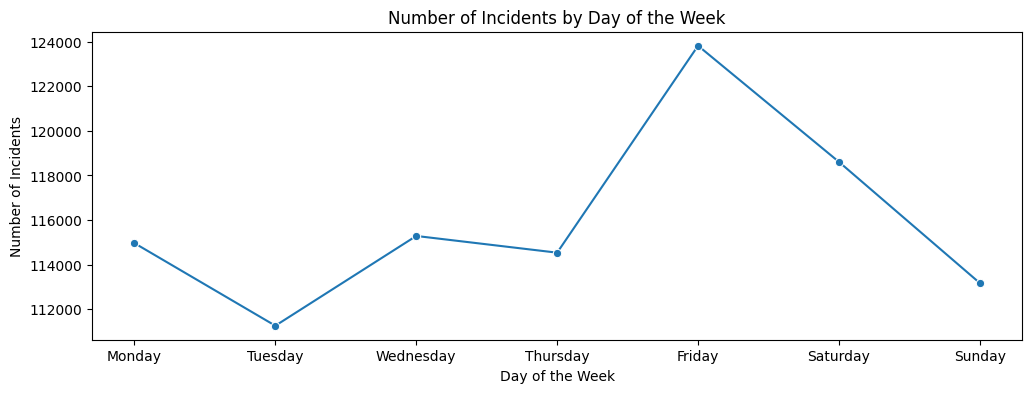

In [40]:
crime_by_day = df['Day_of_Week'].value_counts().reset_index()
crime_by_day.columns = ['day_of_week', 'frequency']

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crime_by_day['day_of_week'] = pd.Categorical(crime_by_day['day_of_week'], categories=days_order, ordered=True)
crime_by_day = crime_by_day.sort_values('day_of_week')
plt.figure(figsize=(12, 4))

sns.lineplot(x='day_of_week', y='frequency', data=crime_by_day, marker='o')


plt.xlabel('Day of the Week')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Day of the Week')
plt.show()

In [41]:
df['Time'] = df['TIME OCC'].astype(str).str.zfill(4)  
df['Time'] = pd.to_datetime(df['TIME OCC'], format='%H:%M:%S').dt.strftime('%H:%M')

df

df['Time_date'] = pd.to_datetime(df['Time'], format='%H:%M')

df['RoundedTime'] = df['Time_date'].dt.round('H').dt.strftime('%H:%M')
df

DR_NO  Date Rptd   DATE OCC  TIME OCC  AREA        AREA NAME  \
0        10304468 2020-01-08 2020-01-08  22:30:00     3        Southwest   
1       190101086 2020-01-02 2020-01-01  03:30:00     1          Central   
2       200110444 2020-04-14 2020-02-13  12:00:00     1          Central   
3       191501505 2020-01-01 2020-01-01  17:30:00    15  North Hollywood   
4       191921269 2020-01-01 2020-01-01  04:15:00    19          Mission   
...           ...        ...        ...       ...   ...              ...   
811658  231604807 2023-01-27 2023-01-26  18:00:00    16         Foothill   
811659  231606525 2023-03-22 2023-03-22  10:00:00    16         Foothill   
811660  231210064 2023-04-12 2023-04-12  16:30:00    12      77th Street   
811661  230115220 2023-07-02 2023-07-01  00:01:00     1          Central   
811662  230906458 2023-03-05 2023-03-05  09:00:00     9         Van Nuys   

        Rpt Dist No  Part 1-2  Crm Cd  \
0               377         2     624   
1               163         2     624   
2               155         2     845   
3              1543         2     745   
4              1998         2     740   
...             ...       ...     ...   
811658         1663         2     740   
811659         1602         1     230   
811660         1239         1     230   
811661          154         1     352   
811662          914         2     745   

                                              Crm Cd Desc  ...  \
0                                BATTERY - SIMPLE ASSAULT  ...   
1                                BATTERY - SIMPLE ASSAULT  ...   
2               SEX OFFENDER REGISTRANT OUT OF COMPLIANCE  ...   
3                VANDALISM - MISDEAMEANOR ($399 OR UNDER)  ...   
4       VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  ...   
...                                                   ...  ...   
811658  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  ...   
811659     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  ...   
811660     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  ...   
811661                                         PICKPOCKET  ...   
811662           VANDALISM - MISDEAMEANOR ($399 OR UNDER)  ...   

                                        LOCATION  Cross Street      LAT  \
0        1100 W  39TH                         PL           NaN  34.0141   
1         700 S  HILL                         ST           NaN  34.0459   
2         200 E  6TH                          ST           NaN  34.0448   
3        5400    CORTEEN                      PL           NaN  34.1685   
4       14400    TITUS                        ST           NaN  34.2198   
...                                          ...           ...      ...   
811658  12500    BRANFORD                     ST           NaN  34.2466   
811659  12800    FILMORE                      ST           NaN  34.2790   
811660   6100 S  VERMONT                      AV           NaN  33.9841   
811661    500 S  MAIN                         ST           NaN  34.0467   
811662  14500    HARTLAND                     ST           NaN  34.1951   

             LON  Year     Month Day_of_Week   Time           Time_date  \
0      -118.2978  2020   January   Wednesday  22:30 1900-01-01 22:30:00   
1      -118.2545  2020   January   Wednesday  03:30 1900-01-01 03:30:00   
2      -118.2474  2020  February    Thursday  12:00 1900-01-01 12:00:00   
3      -118.4019  2020   January   Wednesday  17:30 1900-01-01 17:30:00   
4      -118.4468  2020   January   Wednesday  04:15 1900-01-01 04:15:00   
...          ...   ...       ...         ...    ...                 ...   
811658 -118.4054  2023   January    Thursday  18:00 1900-01-01 18:00:00   
811659 -118.4116  2023     March   Wednesday  10:00 1900-01-01 10:00:00   
811660 -118.2915  2023     April   Wednesday  16:30 1900-01-01 16:30:00   
811661 -118.2485  2023      July    Saturday  00:01 1900-01-01 00:01:00   
811662 -118.4487  2023     March      Sunday  09:00 1900-01-01 09:00:00   

       Roun

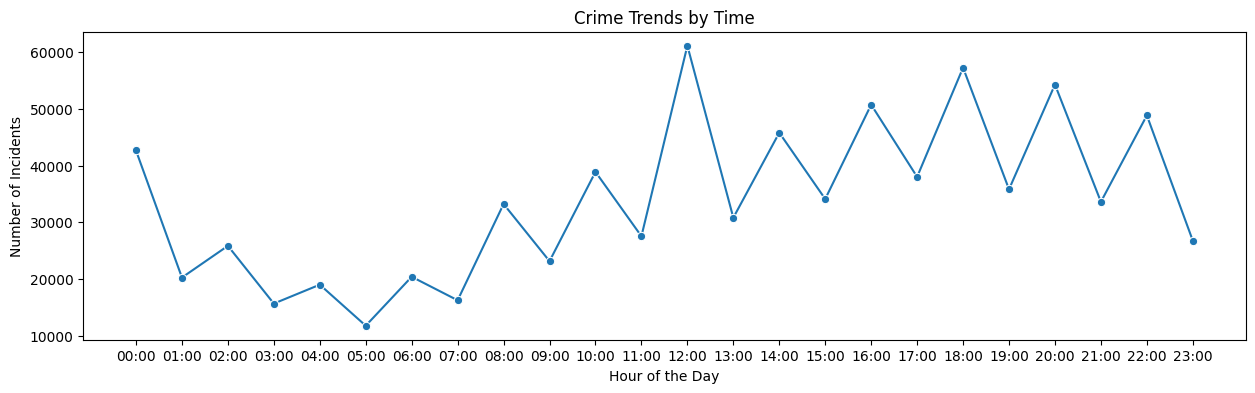

In [42]:
line_chart_data = df.groupby(['RoundedTime']).size().reset_index(name='Incident_Count')
plt.figure(figsize=(15, 4))
sns.lineplot(x='RoundedTime', y='Incident_Count',  data=line_chart_data, marker='o')
plt.title('Crime Trends by Time')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.show()

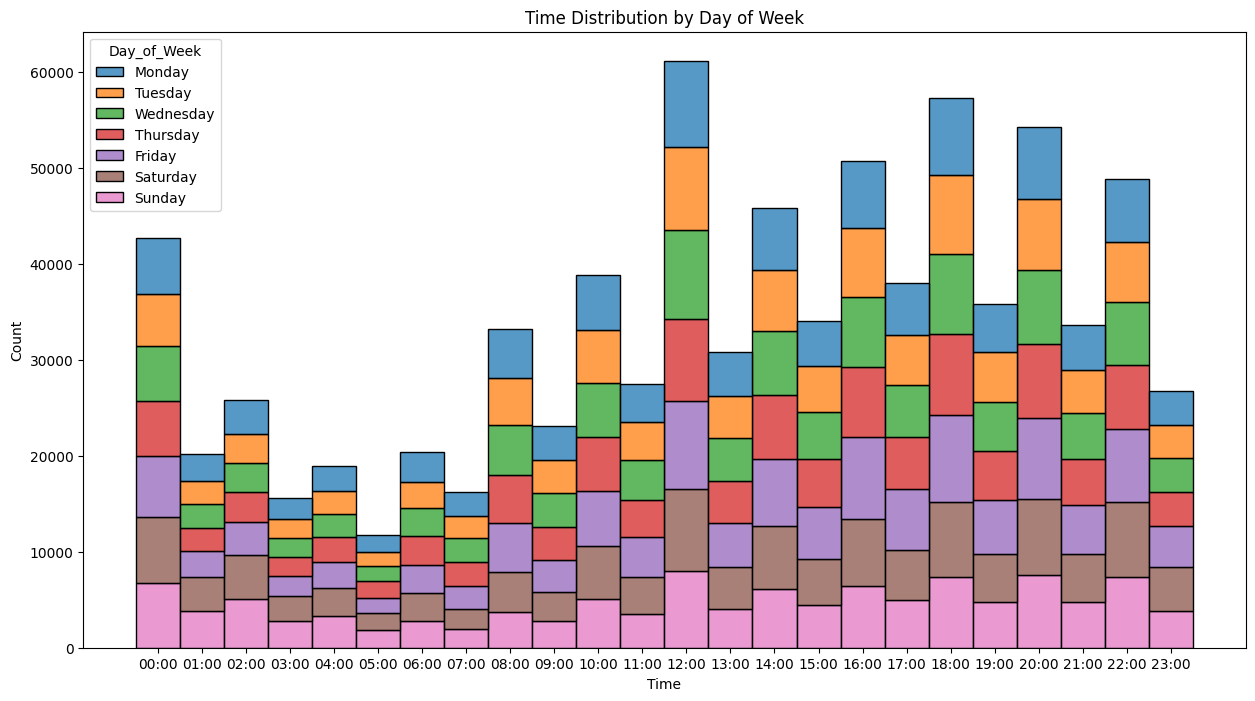

In [43]:
sorted_df = df.sort_values(by='RoundedTime', ascending=True)
sorted_df
plt.figure(figsize=(15, 8))
sns.histplot(data=sorted_df, x='RoundedTime', hue='Day_of_Week', multiple='stack', binwidth=1, hue_order=days_order)
plt.title('Time Distribution by Day of Week')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()


# 7. Impact of Major Events:
Identify major events or policy changes during the dataset period and analyze crime
rate changes before and after these events.

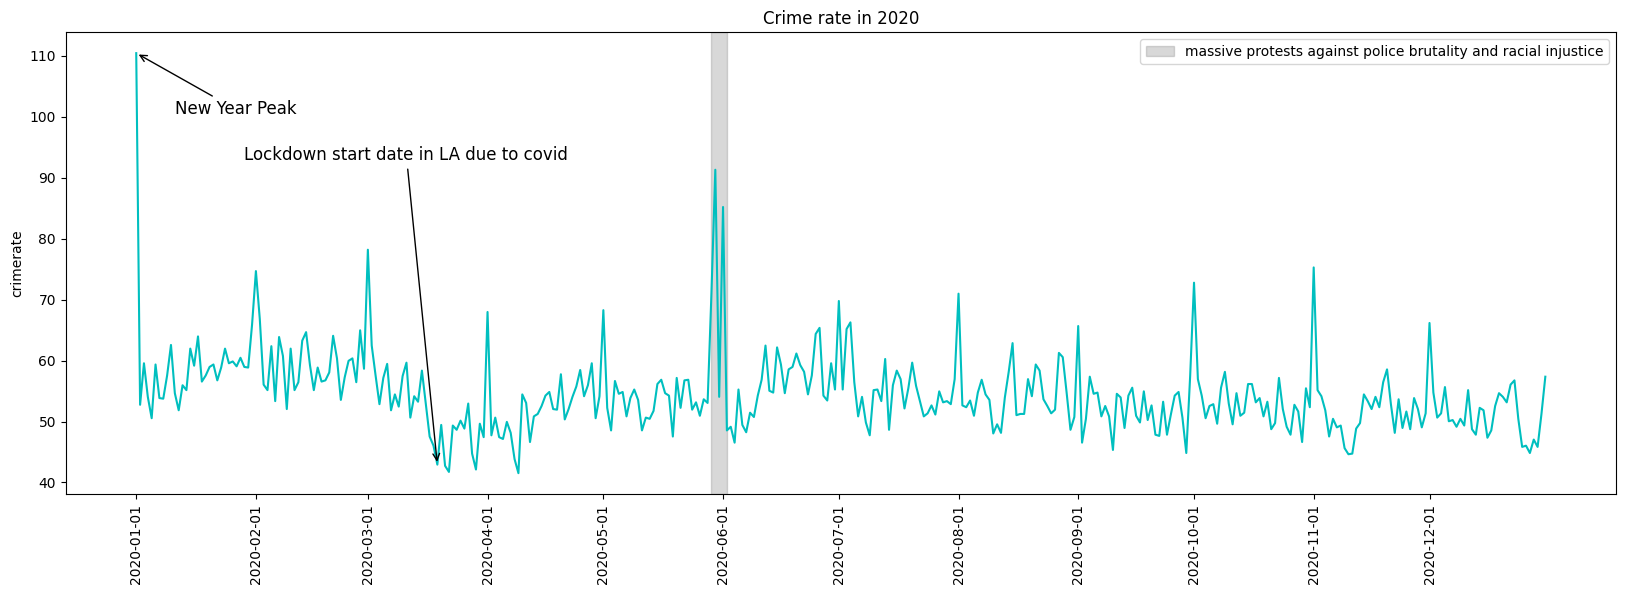

In [44]:
# Create a line plot
plt.figure(figsize=(20, 6))
plt.plot(cr_2020.index, cr_2020['crimerate'], linestyle='-', color='c')

visible_dates = ['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01' ]

NY_2020 = mdates.date2num(pd.to_datetime('2020-01-01'))
cr_ny20 = cr_2020[cr_2020.index == pd.to_datetime('2020-01-01')]['crimerate'].values[0]

plt.axvspan('2020-05-29', '2020-06-02', color='gray', alpha=0.3, label='massive protests against police brutality and racial injustice')

covid_date = mdates.date2num(pd.to_datetime('2020-03-19'))
cr_covid = cr_2020[cr_2020.index == pd.to_datetime('2020-03-19')]['crimerate'].values[0]

# Customize the plot
plt.title('Crime rate in 2020')
plt.ylabel('crimerate')
plt.xticks(visible_dates, rotation=90)

plt.annotate('New Year Peak', xy = (NY_2020, cr_ny20), xytext = (NY_2020 + 10, cr_ny20 - 10),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, color = 'black')

plt.annotate('Lockdown start date in LA due to covid', xy = (covid_date, cr_covid), xytext = (covid_date - 50, cr_covid + 50),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, color = 'black')

plt.legend()

# Show the plot
plt.show()

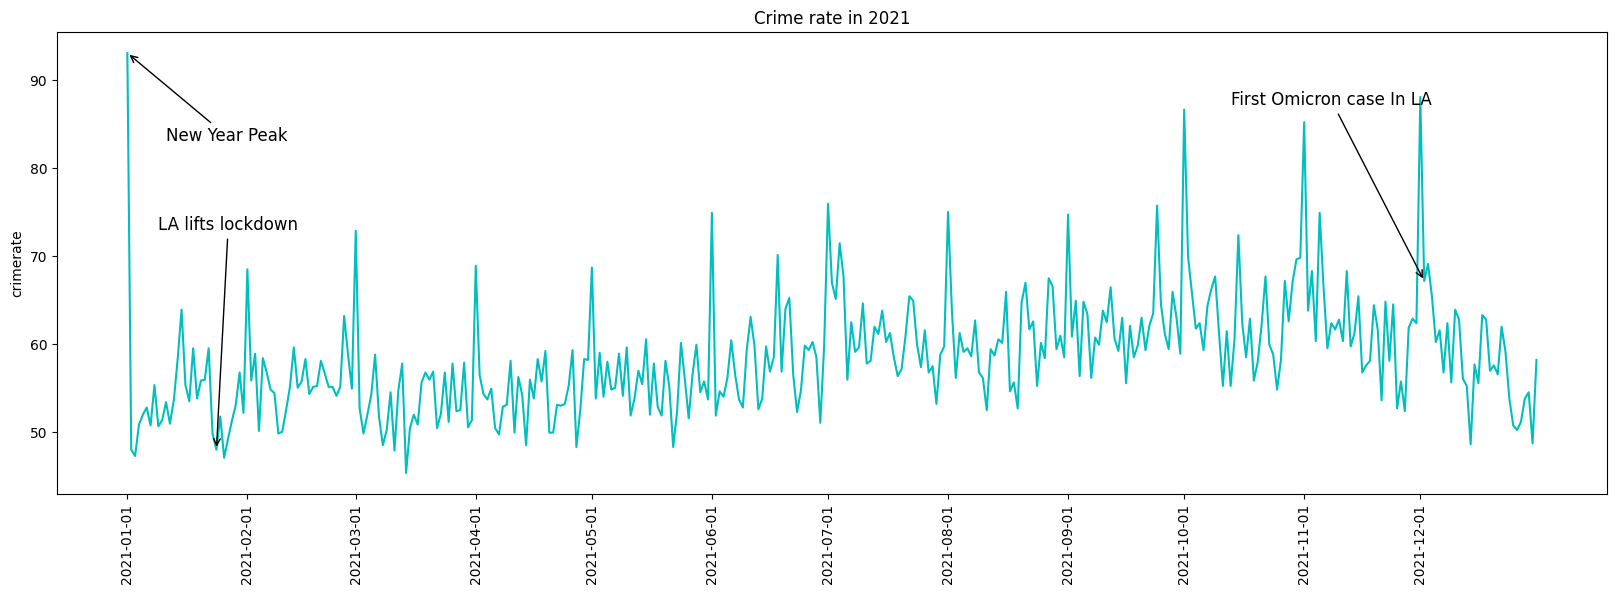

In [45]:
# Create a line plot
plt.figure(figsize=(20, 6))
plt.plot(cr_2021.index, cr_2021['crimerate'], linestyle='-', color='c')

visible_dates = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01' ]

NY_2021 = mdates.date2num(pd.to_datetime('2021-01-01'))
cr_ny21 = cr_2021[cr_2021.index == pd.to_datetime('2021-01-01')]['crimerate'].values[0]

lockdown_lift = mdates.date2num(pd.to_datetime('2021-01-24'))
cr_ll = cr_2021[cr_2021.index == pd.to_datetime('2021-01-24')]['crimerate'].values[0]

omicron_date = mdates.date2num(pd.to_datetime('2021-12-02'))
cr_omicron = cr_2021[cr_2021.index == pd.to_datetime('2021-12-02')]['crimerate'].values[0]


# Customize the plot
plt.title('Crime rate in 2021')
plt.ylabel('crimerate')
plt.xticks(visible_dates, rotation=90)

plt.annotate('New Year Peak', xy = (NY_2021, cr_ny21), xytext = (NY_2021 + 10, cr_ny21 - 10),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, color = 'black')

plt.annotate('LA lifts lockdown', xy = (lockdown_lift, cr_ll), xytext = (lockdown_lift-15, cr_ll + 25),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, color = 'black')

plt.annotate('First Omicron case In LA', xy = (omicron_date, cr_omicron), xytext = (omicron_date - 50, cr_omicron + 20),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, color = 'black')

# Show the plot
plt.show()

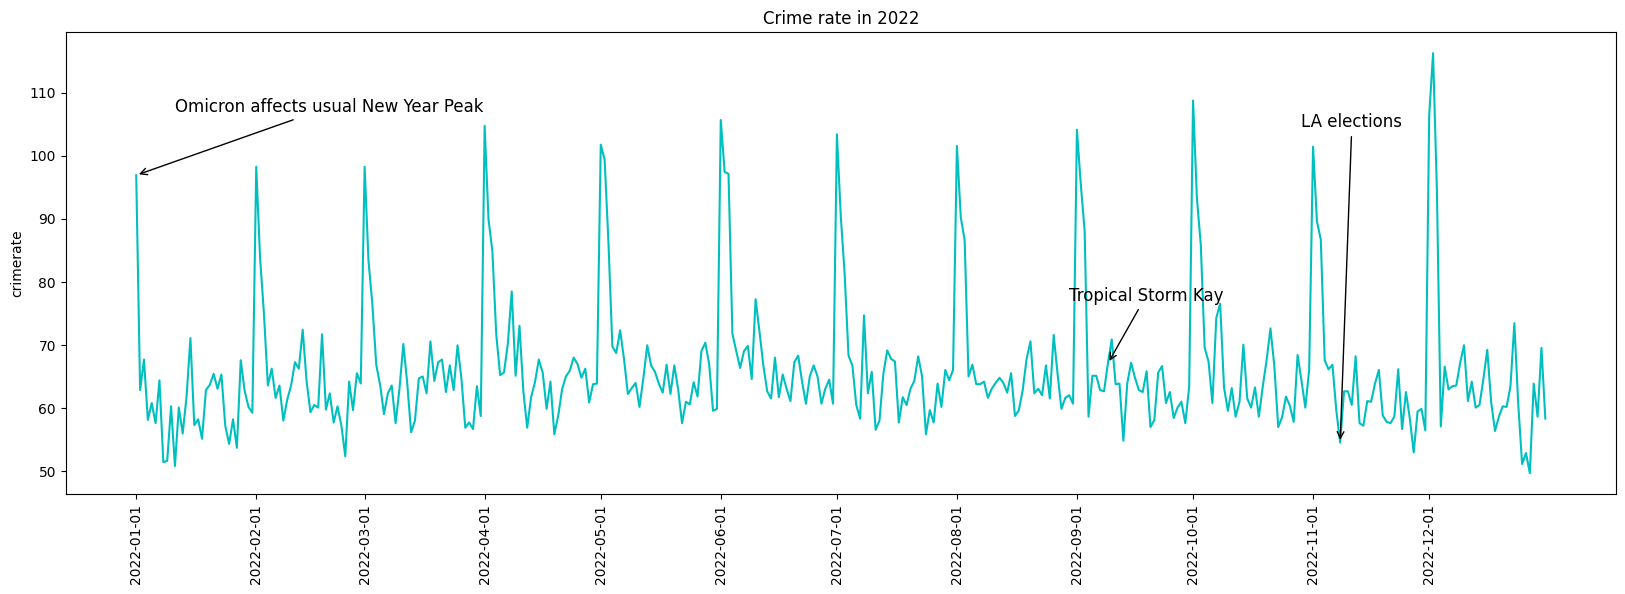

In [46]:
# Create a line plot
plt.figure(figsize=(20, 6))
plt.plot(cr_2022.index, cr_2022['crimerate'], linestyle='-', color='c')

visible_dates = ['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01' ]

NY_2022 = mdates.date2num(pd.to_datetime('2022-01-01'))
cr_ny22 = cr_2022[cr_2022.index == pd.to_datetime('2022-01-01')]['crimerate'].values[0]

storm = mdates.date2num(pd.to_datetime('2022-09-09'))
cr_storm = cr_2022[cr_2022.index == pd.to_datetime('2022-09-09')]['crimerate'].values[0]

elections = mdates.date2num(pd.to_datetime('2022-11-08'))
cr_elections = cr_2022[cr_2022.index == pd.to_datetime('2022-11-08')]['crimerate'].values[0]

# Customize the plot
plt.title('Crime rate in 2022')
plt.ylabel('crimerate')
plt.xticks(visible_dates, rotation=90)

plt.annotate('Omicron affects usual New Year Peak', xy = (NY_2022, cr_ny22), xytext = (NY_2022 + 10, cr_ny22 + 10),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, color = 'black')

plt.annotate('Tropical Storm Kay', xy = (storm, cr_storm), xytext = (storm - 10, cr_storm + 10),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, color = 'black')

plt.annotate('LA elections', xy = (elections, cr_elections), xytext = (elections - 10, cr_elections + 50),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, color = 'black')

# Show the plot
plt.show()

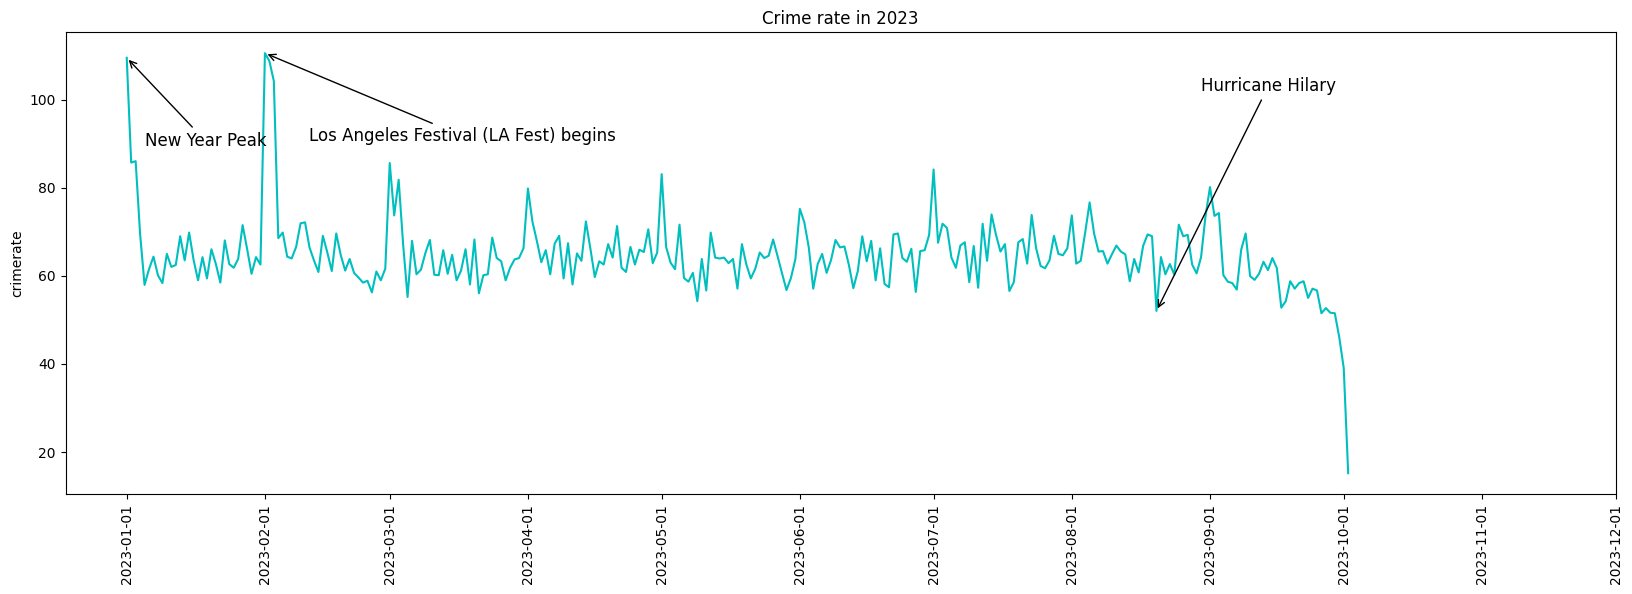

In [47]:
# Create a line plot
plt.figure(figsize=(20, 6))
plt.plot(cr_2023.index, cr_2023['crimerate'], linestyle='-', color='c')

visible_dates = ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01' ]

NY_2023 = mdates.date2num(pd.to_datetime('2023-01-01'))
cr_ny23 = cr_2023[cr_2023.index == pd.to_datetime('2023-01-01')]['crimerate'].values[0]

fest = mdates.date2num(pd.to_datetime('2023-02-01'))
cr_fest = cr_2023[cr_2023.index == pd.to_datetime('2023-02-01')]['crimerate'].values[0]
date2 = mdates.date2num(pd.to_datetime('2023-08-20'))
cr_date2 = cr_2023[cr_2023.index == pd.to_datetime('2023-08-20')]['crimerate'].values[0]

# Customize the plot
plt.title('Crime rate in 2023')
plt.ylabel('crimerate')
plt.xticks(visible_dates, rotation=90)

plt.annotate('Hurricane Hilary', xy = (date2, cr_date2), xytext = (date2 + 10, cr_date2 + 50),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, color = 'black')

plt.annotate('Los Angeles Festival (LA Fest) begins', xy = (fest, cr_fest), xytext = (fest + 10, cr_fest - 20),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, color = 'black')

plt.annotate('New Year Peak', xy = (NY_2023, cr_ny23), xytext = (NY_2023 + 4, cr_ny23 - 20),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=12, color = 'black')

# Show the plot
plt.show()

# 8. Outliers and Anomalies:
 Use statistical methods or data visualization techniques to identify dataset outliers 
 and investigate unusual patterns.

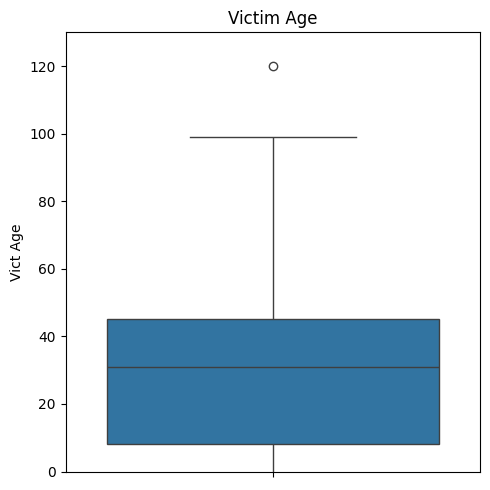

In [48]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

plt1 = sns.boxplot(df['Vict Age'])
plt1.set_title("Victim Age")
plt1.set_ylim(0, df['Vict Age'].max() + 10)
plt.tight_layout()
plt.show()


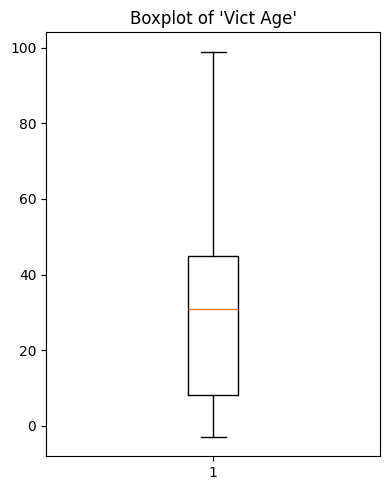

In [49]:
Q1 = df['Vict Age'].quantile(0.25)
Q3 = df['Vict Age'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Vict Age'] >= Q1 - 1.5 * IQR) & (df['Vict Age'] <= Q3 + 1.5 * IQR)]

fig, axs = plt.subplots(1, 1, figsize=(4, 5))

plt.boxplot(df['Vict Age'])
plt.title("Boxplot of 'Vict Age'")  # Corrected line to set the title

plt.tight_layout()
plt.show()

<Axes: >

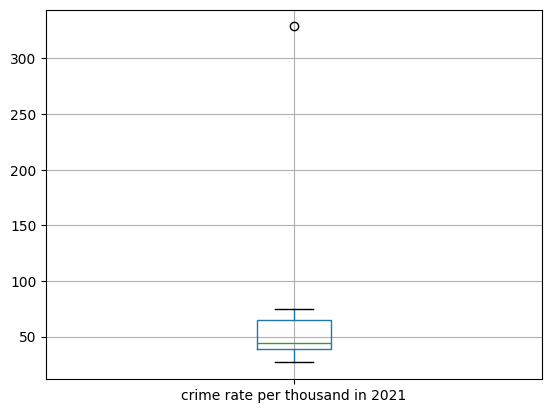

In [50]:
shapefile[['crime rate per thousand in 2021']].boxplot()

# 9. Demographic Factors:
 Analyze the dataset to identify any patterns or correlations between demographic
factors (e.g., age, gender) and specific types of crimes.

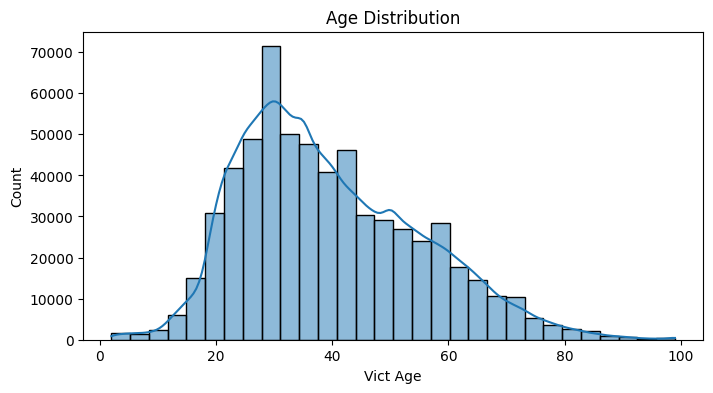

In [51]:
df1 = df[~df['Vict Age'].isin([0,-1,-2,-3])]
plt.figure(figsize=(8, 4))
sns.histplot(df1['Vict Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()


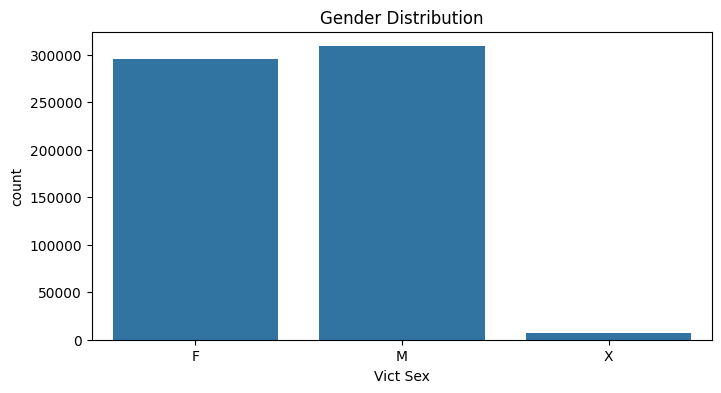

In [52]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Vict Sex', data=df1)
plt.title('Gender Distribution')
plt.show()

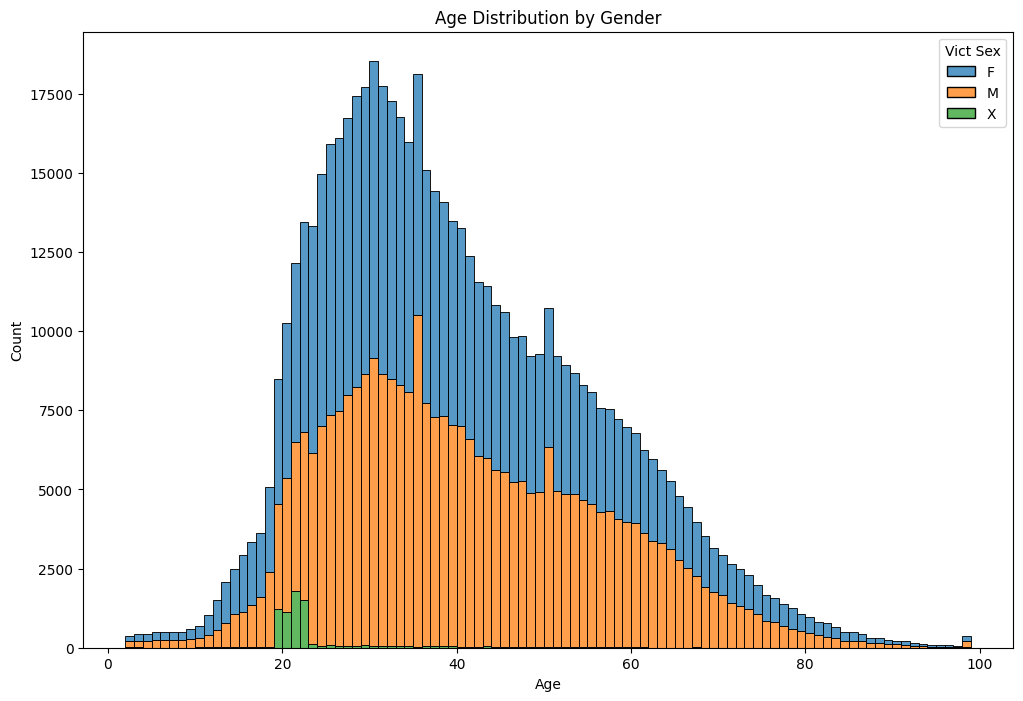

In [53]:
plt.figure(figsize=(12, 8))

sns.histplot(data=df1, x='Vict Age', hue='Vict Sex', multiple="stack", binwidth=1)

plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()

In [54]:
crime_counts = df.groupby(['Vict Sex', 'Crm Cd Desc']).size().reset_index(name='crime_count')

In [55]:
sorted_counts = crime_counts.sort_values(by='crime_count', ascending=False)
sorted_counts

Vict Sex                                     Crm Cd Desc  crime_count
261        M                                VEHICLE - STOLEN        41402
126        F                                VEHICLE - STOLEN        36680
136        M                        BATTERY - SIMPLE ASSAULT        33865
134        M  ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT        33364
70         F               INTIMATE PARTNER - SIMPLE ASSAULT        31003
..       ...                                             ...          ...
62         F                       GRAND THEFT / AUTO REPAIR            1
61         F        FIREARMS RESTRAINING ORDER (FIREARMS RO)            1
222        M                       PURSE SNATCHING - ATTEMPT            1
219        M                                         PIMPING            1
327        X        FIREARMS RESTRAINING ORDER (FIREARMS RO)            1

[395 rows x 3 columns]

In [56]:
crimes = ['VEHICLE - STOLEN',
 'BATTERY - SIMPLE ASSAULT',
 'THEFT OF IDENTITY','BURGLARY FROM VEHICLE',
 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)']

df2 = sorted_counts[sorted_counts['Crm Cd Desc'].isin(crimes)]
df2

Vict Sex                                        Crm Cd Desc  crime_count
261        M                                   VEHICLE - STOLEN        41402
126        F                                   VEHICLE - STOLEN        36680
136        M                           BATTERY - SIMPLE ASSAULT        33865
4          F                           BATTERY - SIMPLE ASSAULT        30338
111        F                                  THEFT OF IDENTITY        30003
153        M                              BURGLARY FROM VEHICLE        27968
258        M  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...        22939
244        M                                  THEFT OF IDENTITY        20898
21         F                              BURGLARY FROM VEHICLE        20745
123        F  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...        17130
386        X  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...         9445
389        X                                   VEHICLE - STOLEN         8734
286        X                              BURGLARY FROM VEHICLE         1095
372        X                                  THEFT OF IDENTITY          637
271        X                           BATTERY - SIMPLE ASSAULT          378

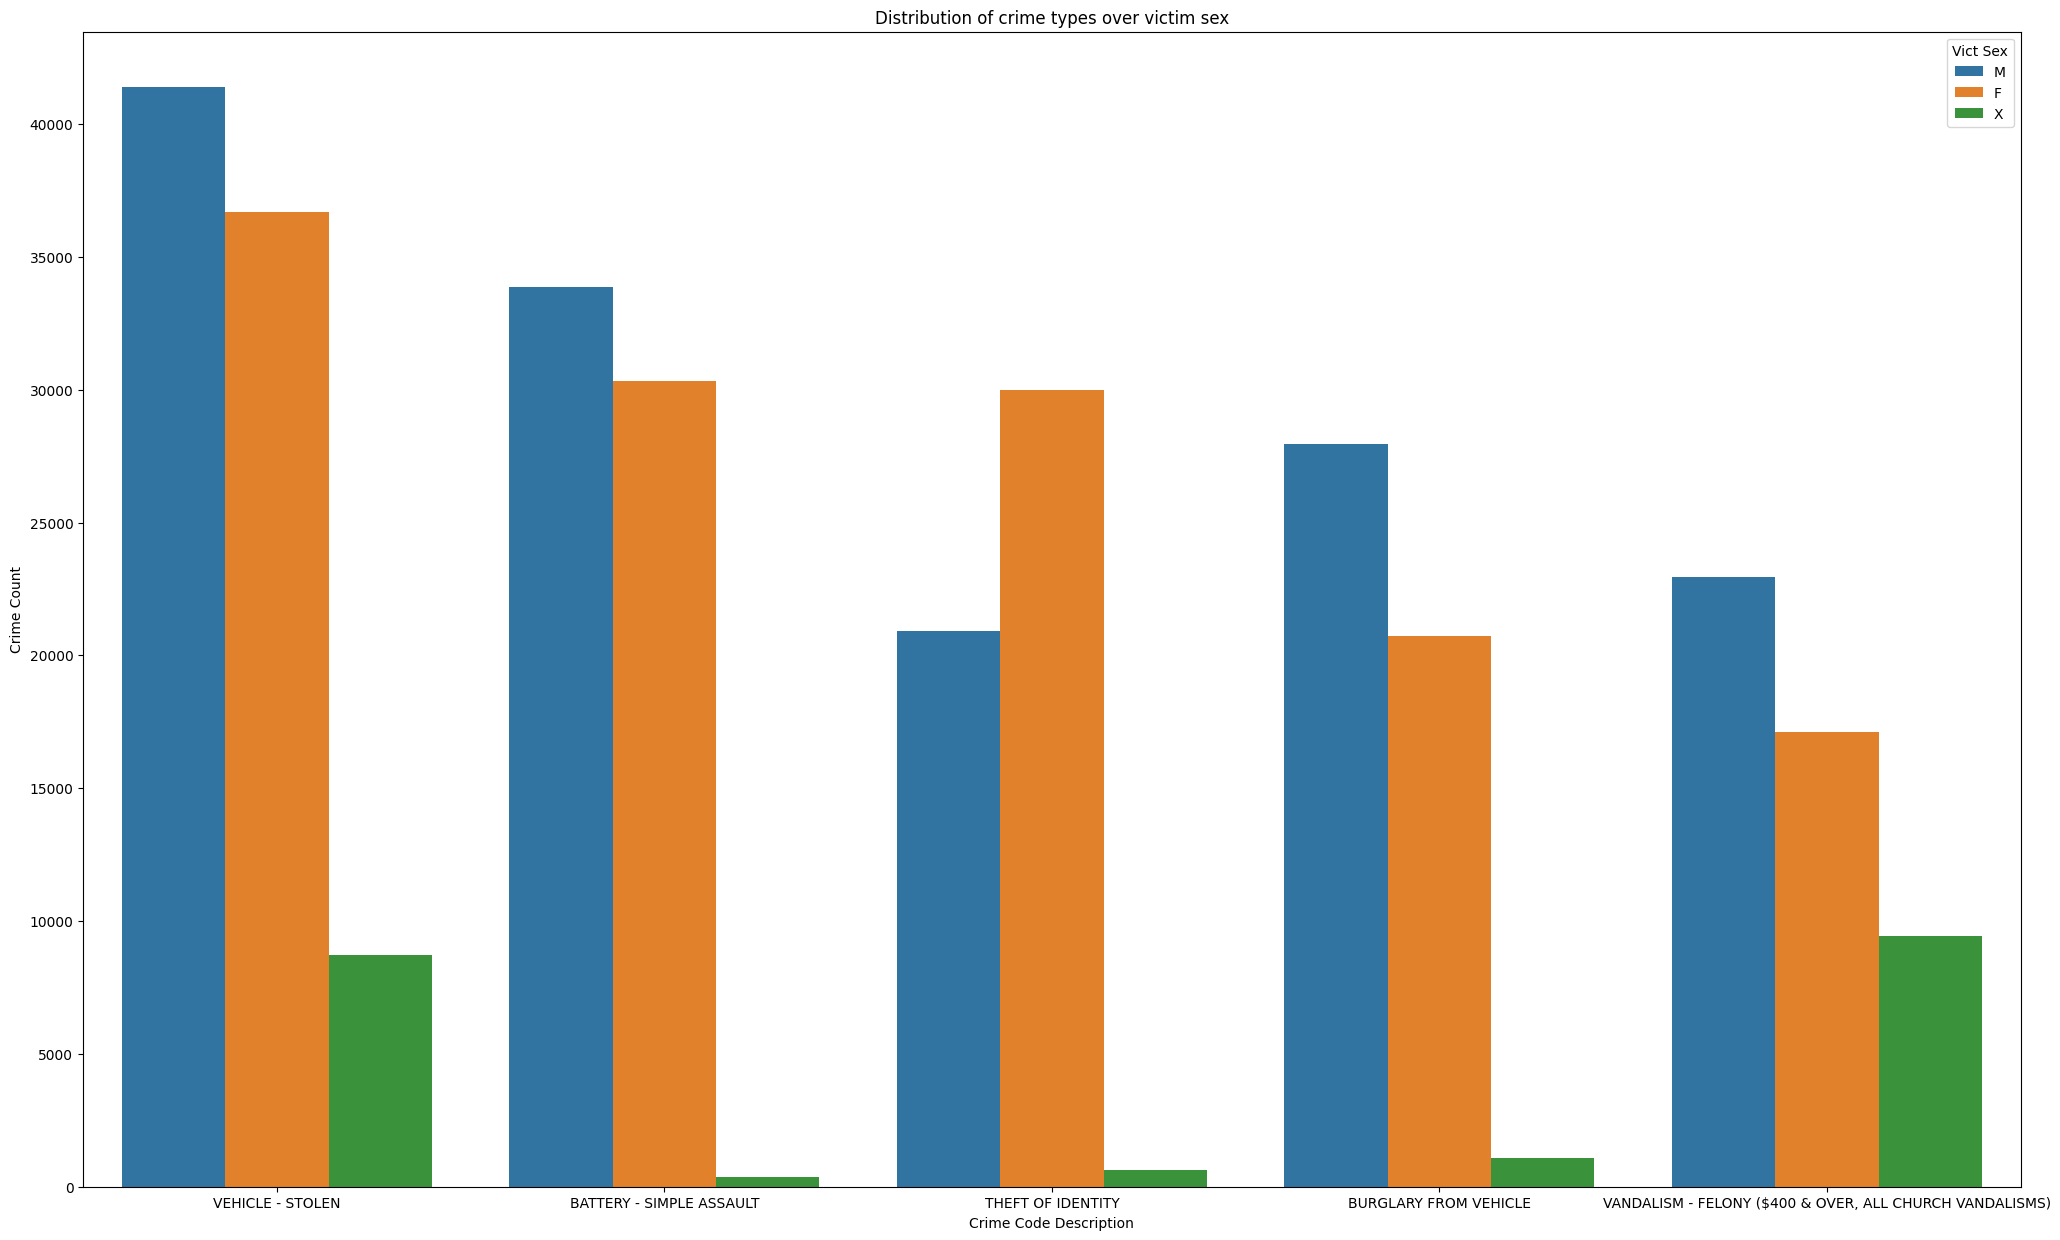

In [57]:
plt.figure(figsize=(25, 15))
sns.barplot(x='Crm Cd Desc', y='crime_count', hue='Vict Sex', data=df2, errorbar=None)
plt.title('Distribution of crime types over victim sex')
plt.xlabel('Crime Code Description')
plt.ylabel('Crime Count')
plt.show()


In [58]:
df1 = df

In [59]:
df1['age_bin'] = pd.cut(df['Vict Age'], bins=range(0, 100, 20), right=False)
df1

C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\1904615664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['age_bin'] = pd.cut(df['Vict Age'], bins=range(0, 100, 20), right=False)


DR_NO  Date Rptd   DATE OCC  TIME OCC  AREA        AREA NAME  \
0        10304468 2020-01-08 2020-01-08  22:30:00     3        Southwest   
1       190101086 2020-01-02 2020-01-01  03:30:00     1          Central   
2       200110444 2020-04-14 2020-02-13  12:00:00     1          Central   
3       191501505 2020-01-01 2020-01-01  17:30:00    15  North Hollywood   
4       191921269 2020-01-01 2020-01-01  04:15:00    19          Mission   
...           ...        ...        ...       ...   ...              ...   
811658  231604807 2023-01-27 2023-01-26  18:00:00    16         Foothill   
811659  231606525 2023-03-22 2023-03-22  10:00:00    16         Foothill   
811660  231210064 2023-04-12 2023-04-12  16:30:00    12      77th Street   
811661  230115220 2023-07-02 2023-07-01  00:01:00     1          Central   
811662  230906458 2023-03-05 2023-03-05  09:00:00     9         Van Nuys   

        Rpt Dist No  Part 1-2  Crm Cd  \
0               377         2     624   
1               163         2     624   
2               155         2     845   
3              1543         2     745   
4              1998         2     740   
...             ...       ...     ...   
811658         1663         2     740   
811659         1602         1     230   
811660         1239         1     230   
811661          154         1     352   
811662          914         2     745   

                                              Crm Cd Desc  ... Cross Street  \
0                                BATTERY - SIMPLE ASSAULT  ...          NaN   
1                                BATTERY - SIMPLE ASSAULT  ...          NaN   
2               SEX OFFENDER REGISTRANT OUT OF COMPLIANCE  ...          NaN   
3                VANDALISM - MISDEAMEANOR ($399 OR UNDER)  ...          NaN   
4       VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  ...          NaN   
...                                                   ...  ...          ...   
811658  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  ...          NaN   
811659     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  ...          NaN   
811660     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  ...          NaN   
811661                                         PICKPOCKET  ...          NaN   
811662           VANDALISM - MISDEAMEANOR ($399 OR UNDER)  ...          NaN   

            LAT       LON  Year     Month Day_of_Week   Time  \
0       34.0141 -118.2978  2020   January   Wednesday  22:30   
1       34.0459 -118.2545  2020   January   Wednesday  03:30   
2       34.0448 -118.2474  2020  February    Thursday  12:00   
3       34.1685 -118.4019  2020   January   Wednesday  17:30   
4       34.2198 -118.4468  2020   January   Wednesday  04:15   
...         ...       ...   ...       ...         ...    ...   
811658  34.2466 -118.4054  2023   January    Thursday  18:00   
811659  34.2790 -118.4116  2023     March   Wednesday  10:00   
811660  33.9841 -118.2915  2023     April   Wednesday  16:30   
811661  34.0467 -118.2485  2023      July    Saturday  00:01   
811662  34.1951 -118.4487  2023     March      Sunday  09:00   

                 Time_date RoundedTime   age_bin  
0      1900-01-01 22:30:00       22:00  [20, 40)  
1      1900-01-01 03:30:00       04:00  [20, 40)  
2      1900-01-01 12:00:00       12:00   [0, 20)  
3      1900-01-01 17:30:00       18:00  [60, 80)  
4      1900-01-01 04:15:00       04:00  [20, 40)  
...                    ...         ...       ...  
811658 1900-01-01 18:00:00       18:00  [20, 40)  
811659 1900-01-01 10:00:00       10:00  [20, 40)  
811660 1900-01-01 16:30:00       16:00  [20, 40)  
811661 1900-01-01 00:01:00       00:00  [20, 40)  
811662 1900-01-01 09:00:00       09:00  [40, 60)  

[811662 rows x 35 columns]

In [60]:
crime_counts2 = df1.groupby(['age_bin', 'Crm Cd Desc']).size().reset_index(name='crime_count')
crime_counts2

age_bin                                        Crm Cd Desc  crime_count
0     [0, 20)                                              ARSON          991
1     [0, 20)       ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER          772
2     [0, 20)     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT         5247
3     [0, 20)                                  ATTEMPTED ROBBERY          831
4     [0, 20)                           BATTERY - SIMPLE ASSAULT         5769
..        ...                                                ...          ...
547  [60, 80)  VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, B...           43
548  [60, 80)                           VIOLATION OF COURT ORDER          705
549  [60, 80)                     VIOLATION OF RESTRAINING ORDER         1544
550  [60, 80)           VIOLATION OF TEMPORARY RESTRAINING ORDER          116
551  [60, 80)                         WEAPONS POSSESSION/BOMBING            1

[552 rows x 3 columns]

In [61]:
sorted_counts2 = crime_counts2.sort_values(by='crime_count', ascending=False)
sorted_counts2

age_bin                                  Crm Cd Desc  crime_count
132   [0, 20)                             VEHICLE - STOLEN        86567
159  [20, 40)                        BURGLARY FROM VEHICLE        29311
142  [20, 40)                     BATTERY - SIMPLE ASSAULT        28225
211  [20, 40)            INTIMATE PARTNER - SIMPLE ASSAULT        27042
253  [20, 40)                            THEFT OF IDENTITY        26235
..        ...                                          ...          ...
300  [40, 60)                            CHILD ABANDONMENT            0
439  [60, 80)  CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT            0
441  [60, 80)               CHILD ANNOYING (17YRS & UNDER)            0
289  [40, 60)                                BOAT - STOLEN            0
472  [60, 80)                          FAILURE TO DISPERSE            0

[552 rows x 3 columns]

In [62]:
crimes = ['ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
 'BATTERY - SIMPLE ASSAULT',
 'THEFT OF IDENTITY','BURGLARY FROM VEHICLE',
 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)']

df3 = sorted_counts2[sorted_counts2['Crm Cd Desc'].isin(crimes)]
df3

age_bin                                        Crm Cd Desc  crime_count
159  [20, 40)                              BURGLARY FROM VEHICLE        29311
142  [20, 40)                           BATTERY - SIMPLE ASSAULT        28225
253  [20, 40)                                  THEFT OF IDENTITY        26235
140  [20, 40)     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT        22821
280  [40, 60)                           BATTERY - SIMPLE ASSAULT        21159
267  [20, 40)  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...        18534
391  [40, 60)                                  THEFT OF IDENTITY        16752
297  [40, 60)                              BURGLARY FROM VEHICLE        14259
278  [40, 60)     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT        14164
405  [40, 60)  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...        13143
129   [0, 20)  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...        12870
418  [60, 80)                           BATTERY - SIMPLE ASSAULT         8684
529  [60, 80)                                  THEFT OF IDENTITY         6182
4     [0, 20)                           BATTERY - SIMPLE ASSAULT         5769
2     [0, 20)     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT         5247
543  [60, 80)  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...         4599
416  [60, 80)     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT         4203
435  [60, 80)                              BURGLARY FROM VEHICLE         3892
21    [0, 20)                              BURGLARY FROM VEHICLE         2118
115   [0, 20)                                  THEFT OF IDENTITY         1633

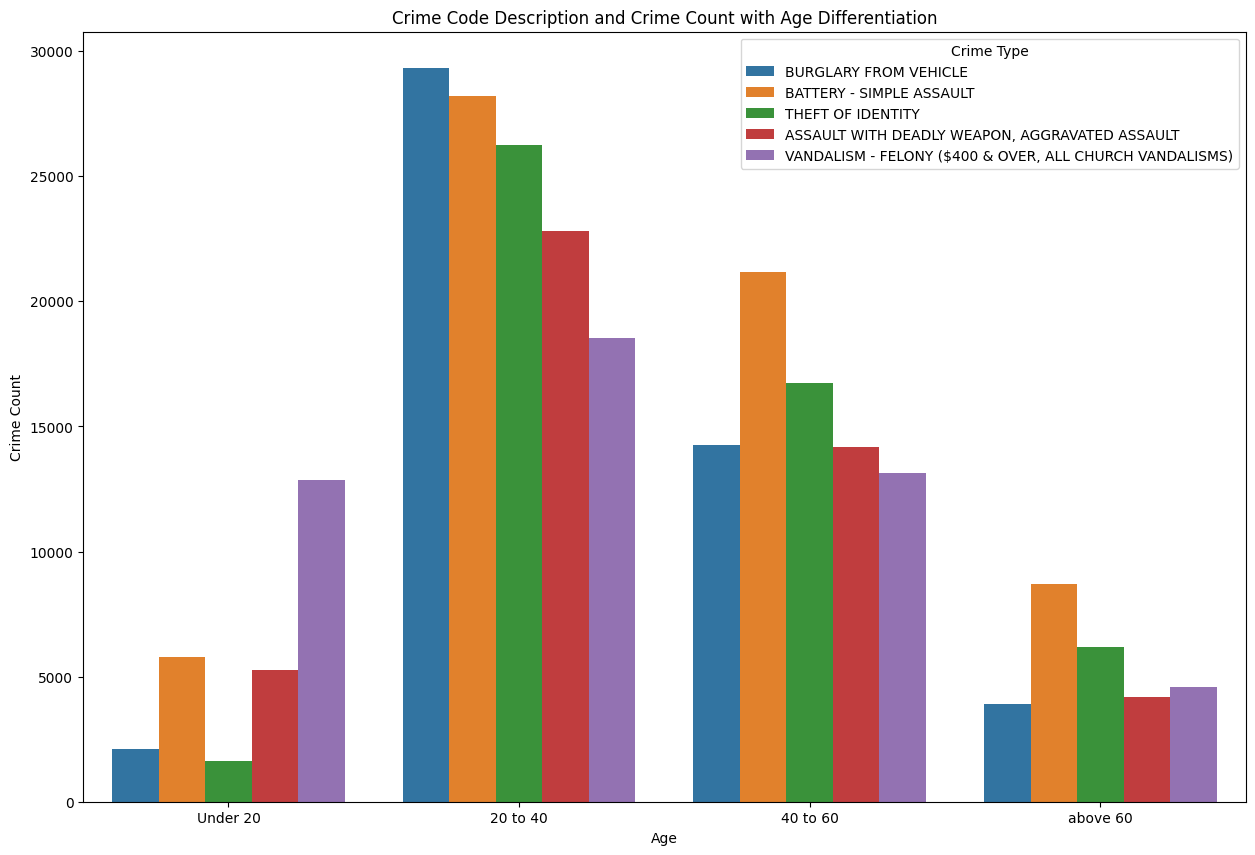

In [63]:
plt.figure(figsize=(15, 10))
sns.barplot(x='age_bin', y='crime_count', hue='Crm Cd Desc', data=df3, errorbar=None)
plt.xticks(range(4), ['Under 20', '20 to 40', '40 to 60', 'above 60'])
plt.title('Crime Code Description and Crime Count with Age Differentiation')
plt.xlabel('Age')
plt.ylabel('Crime Count')
plt.legend(title='Crime Type')
plt.show()


# 10. Predicting Future Trends:
Employ time series forecasting methods, such as ARIMA or Prophet, to predict
future crime trends based on historical data. Consider incorporating relevant
external factors into your models.

In [64]:
df_prediction = df
df_prediction['Date Rptd'] = pd.to_datetime(df_prediction['Date Rptd'])
df_prediction['Date Rptd'] = df_prediction['Date Rptd'].dt.date
df_prediction['DATE OCC'] = pd.to_datetime(df_prediction['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
df_prediction['DATE OCC'] = df_prediction['DATE OCC'].dt.date
df_prediction.head()

C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\308486440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction['Date Rptd'] = pd.to_datetime(df_prediction['Date Rptd'])
C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\308486440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction['Date Rptd'] = df_prediction['Date Rptd'].dt.date
C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\308486440.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

DR_NO   Date Rptd    DATE OCC  TIME OCC  AREA        AREA NAME  \
0   10304468  2020-01-08  2020-01-08  22:30:00     3        Southwest   
1  190101086  2020-01-02  2020-01-01  03:30:00     1          Central   
2  200110444  2020-04-14  2020-02-13  12:00:00     1          Central   
3  191501505  2020-01-01  2020-01-01  17:30:00    15  North Hollywood   
4  191921269  2020-01-01  2020-01-01  04:15:00    19          Mission   

   Rpt Dist No  Part 1-2  Crm Cd  \
0          377         2     624   
1          163         2     624   
2          155         2     845   
3         1543         2     745   
4         1998         2     740   

                                         Crm Cd Desc  ... Cross Street  \
0                           BATTERY - SIMPLE ASSAULT  ...          NaN   
1                           BATTERY - SIMPLE ASSAULT  ...          NaN   
2          SEX OFFENDER REGISTRANT OUT OF COMPLIANCE  ...          NaN   
3           VANDALISM - MISDEAMEANOR ($399 OR UNDER)  ...          NaN   
4  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  ...          NaN   

       LAT       LON  Year     Month Day_of_Week   Time           Time_date  \
0  34.0141 -118.2978  2020   January   Wednesday  22:30 1900-01-01 22:30:00   
1  34.0459 -118.2545  2020   January   Wednesday  03:30 1900-01-01 03:30:00   
2  34.0448 -118.2474  2020  February    Thursday  12:00 1900-01-01 12:00:00   
3  34.1685 -118.4019  2020   January   Wednesday  17:30 1900-01-01 17:30:00   
4  34.2198 -118.4468  2020   January   Wednesday  04:15 1900-01-01 04:15:00   

  RoundedTime   age_bin  
0       22:00  [20, 40)  
1       04:00  [20, 40)  
2       12:00   [0, 20)  
3       18:00  [60, 80)  
4       04:00  [20, 40)  

[5 rows x 35 columns]

C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\2057554610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction['DATE OCC'] = pd.to_datetime(df_prediction['DATE OCC'])


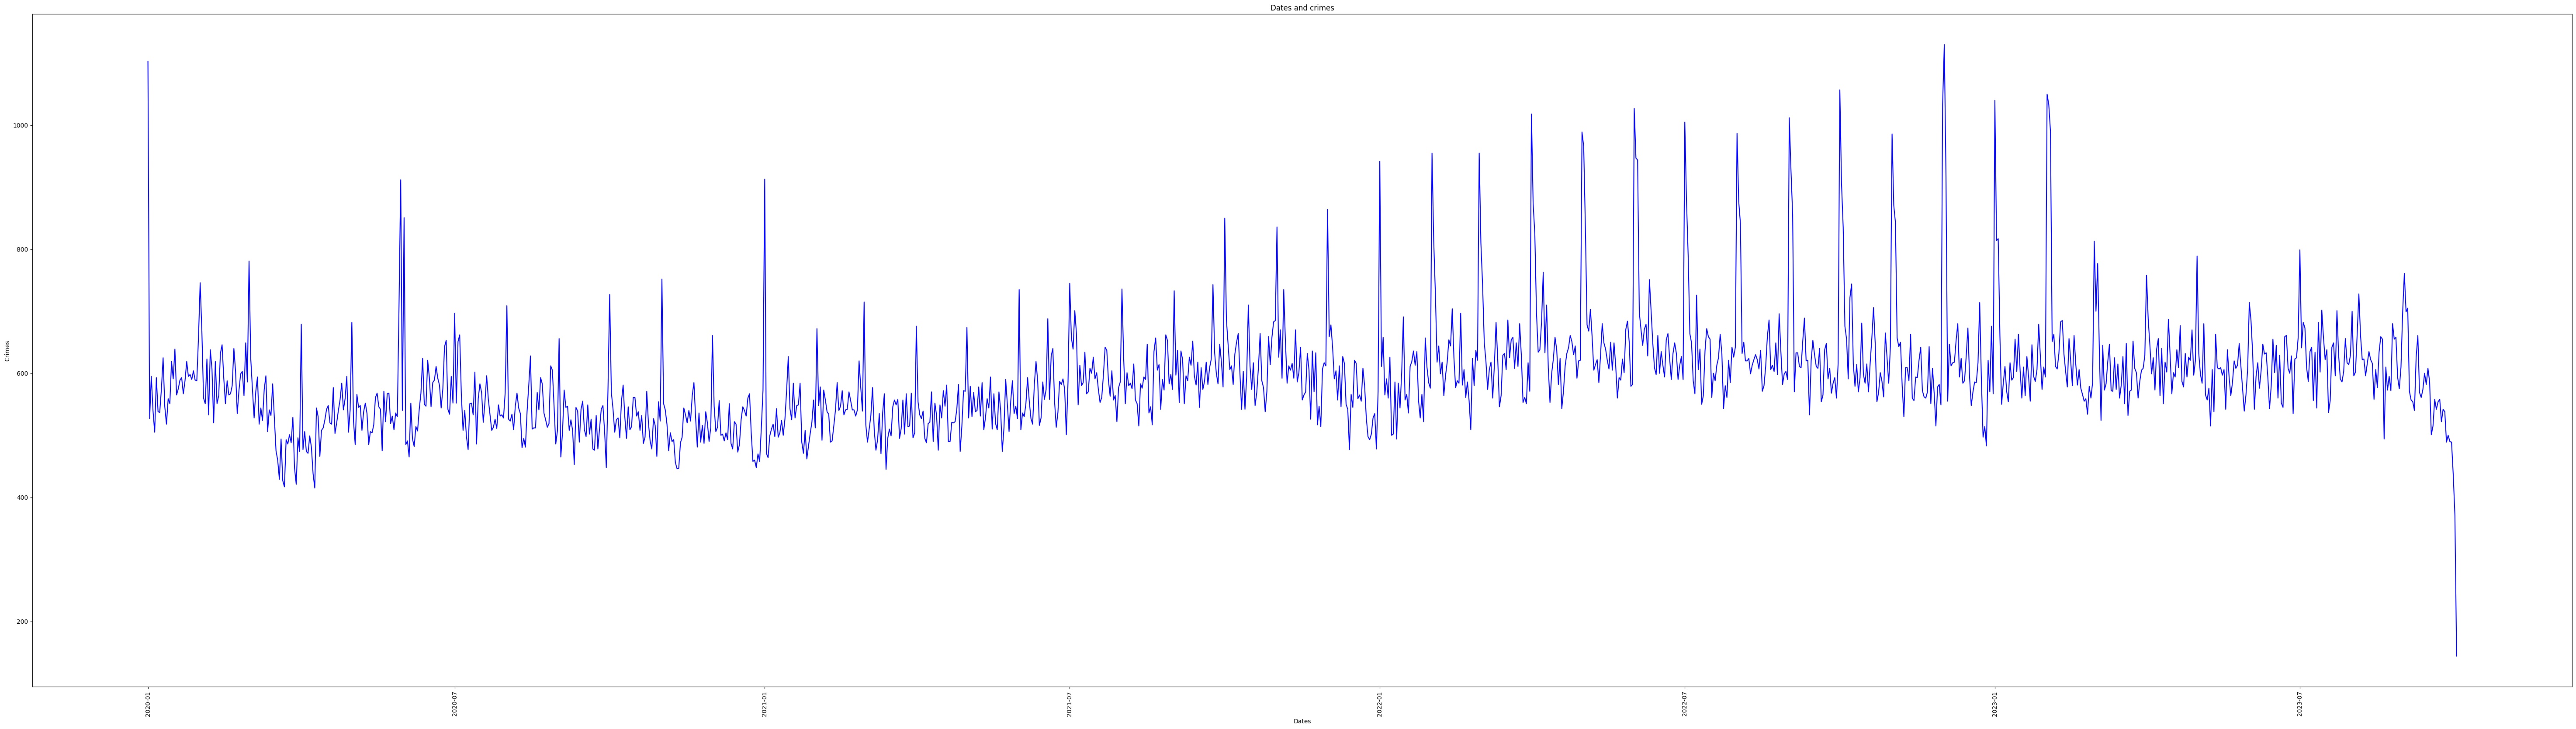

In [65]:
df_prediction['DATE OCC'] = pd.to_datetime(df_prediction['DATE OCC'])
crime_counts = df_prediction.groupby('DATE OCC').size()
cc_df = pd.DataFrame(crime_counts)
# Extract months and average crimes from the data
dates = crime_counts.index
crimes = crime_counts.values

# Create a line plot
plt.figure(figsize=(75, 20))
plt.plot(dates, crimes, linestyle='-', color='b')

# Customize the plot
plt.title('Dates and crimes')
plt.xlabel('Dates')
plt.ylabel('Crimes')
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [66]:
#crimes recorded per year
df_prediction['DATE OCC'] = pd.to_datetime(df_prediction['DATE OCC'])
df_prediction['Month'] = df_prediction['DATE OCC'].dt.month_name()
df_prediction['Year'] = df_prediction['DATE OCC'].dt.year
cpy = df_prediction.groupby('Year').size()
cpy_df = pd.DataFrame(cpy)
cpy_df

C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\3305041548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction['DATE OCC'] = pd.to_datetime(df_prediction['DATE OCC'])
C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\3305041548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction['Month'] = df_prediction['DATE OCC'].dt.month_name()
C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\3305041548.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

0
Year        
2020  199391
2021  209326
2022  234172
2023  168773

In [67]:
#Population data of LA
pop2020 = 9992236
pop2021 = 9811842
pop2022 = 9721138
pop2023 = 9500000

cpy_df['Population'] = [pop2020, pop2021, pop2022, pop2023]
cpy_df

0  Population
Year                    
2020  199391     9992236
2021  209326     9811842
2022  234172     9721138
2023  168773     9500000

In [68]:
cpy_df['crimerate'] = (cpy_df[0]/cpy_df['Population'])*1000
cpy_df

0  Population  crimerate
Year                               
2020  199391     9992236  19.954593
2021  209326     9811842  21.334017
2022  234172     9721138  24.088949
2023  168773     9500000  17.765579

In [69]:
cc_df.index = pd.to_datetime(cc_df.index)
cc_df['Year'] = cc_df.index.year
cr_2020 = cc_df[cc_df['Year'] == 2020]
cr_2021 = cc_df[cc_df['Year'] == 2021]
cr_2022 = cc_df[cc_df['Year'] == 2022]
cr_2023 = cc_df[cc_df['Year'] == 2023]

cr_2020['crimerate'] = (cr_2020[0]/pop2020)*1000000
cr_2021['crimerate'] = (cr_2021[0]/pop2021)*1000000
cr_2022['crimerate'] = (cr_2022[0]/pop2022)*1000000
cr_2023['crimerate'] = (cr_2023[0]/pop2023)*1000000

C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\1047125325.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cr_2020['crimerate'] = (cr_2020[0]/pop2020)*1000000
C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\1047125325.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cr_2021['crimerate'] = (cr_2021[0]/pop2021)*1000000
C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\1047125325.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [70]:
cr_2023

0  Year   crimerate
DATE OCC                          
2023-01-01  1040  2023  109.473684
2023-01-02   814  2023   85.684211
2023-01-03   817  2023   86.000000
2023-01-04   660  2023   69.473684
2023-01-05   550  2023   57.894737
...          ...   ...         ...
2023-09-28   490  2023   51.578947
2023-09-29   489  2023   51.473684
2023-09-30   437  2023   46.000000
2023-10-01   371  2023   39.052632
2023-10-02   144  2023   15.157895

[275 rows x 3 columns]

#### Plot of Crime Rates from 2020 - 2023 October

In [71]:
daily_crime_rate=pd.DataFrame()
daily_crime_rate=pd.concat((cr_2020,cr_2021,cr_2022,cr_2023), axis=0)
daily_crime_rate.reset_index(inplace=True)

Text(0, 0.5, 'Crime rate')

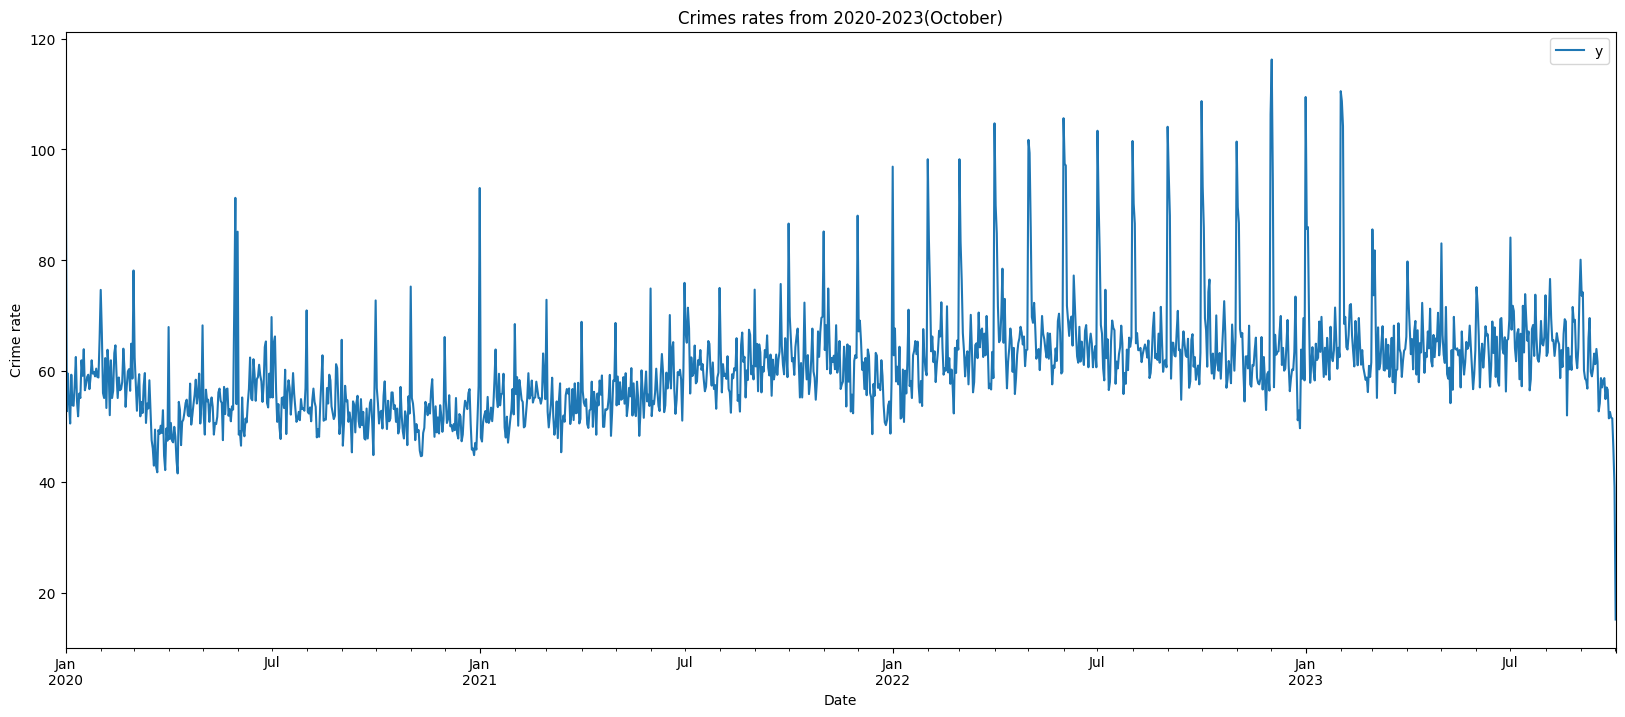

In [72]:
df=daily_crime_rate[['DATE OCC','crimerate']]
df.columns=['ds','y']
df.plot(x='ds',y='y',figsize=(20,8))
plt.title('Crimes rates from 2020-2023(October)')
plt.xlabel('Date')
plt.ylabel('Crime rate')

#### Splitting data as train (data before Jan 2023) and test (data after Jan 2023)

In [73]:
split_date="2023-01-01"
train=df.loc[df.ds<split_date].copy()
test=df.loc[df.ds>=split_date].copy()
train

ds           y
0    2020-01-01  110.385703
1    2020-01-02   52.740948
2    2020-01-03   59.546232
3    2020-01-04   54.041958
4    2020-01-05   50.539239
...         ...         ...
1091 2022-12-27   49.685541
1092 2022-12-28   63.881410
1093 2022-12-29   58.635110
1094 2022-12-30   69.539184
1095 2022-12-31   58.326505

[1096 rows x 2 columns]

#### Adfuller Test to check whether data is stationary

In [74]:
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(train['y'])
p_value=adf_test[1]
print(round(p_value,4))

0.0329


In [75]:
alpha=0.05
if p_value < alpha:
    result = "Reject the null hypothesis. The time series is stationary."
else:
    result = "Fail to reject the null hypothesis. Ther is no evidence to prove that the time series is stationary,so it is non stationary."
result

'Reject the null hypothesis. The time series is stationary.'

#### Fitting a Prophet model on Train data set and Predicting with test data

In [76]:
# !pip install prophet

In [77]:
import prophet
from prophet.plot import plot_plotly,plot_components_plotly
from prophet import Prophet

m=Prophet()
m.fit(train)

18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:06 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
forecast=m.predict(test)
forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-01-01  66.015209   51.394130   71.022011    66.015209    66.015209   
1 2023-01-02  66.013848   52.480756   71.666682    66.013848    66.013848   
2 2023-01-03  66.012486   50.830957   69.387113    66.012486    66.012486   
3 2023-01-04  66.011125   52.748571   72.900370    66.011125    66.011125   
4 2023-01-05  66.009764   53.671766   71.741784    66.009764    66.009764   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -5.126880             -5.126880             -5.126880 -1.502984   
1       -3.801141             -3.801141             -3.801141 -0.388000   
2       -5.289581             -5.289581             -5.289581 -2.113330   
3       -3.402399             -3.402399             -3.402399 -0.484732   
4       -3.564298             -3.564298             -3.564298 -0.922108   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -1.502984     -1.502984 -3.623896     -3.623896     -3.623896   
1     -0.388000     -0.388000 -3.413141     -3.413141     -3.413141   
2     -2.113330     -2.113330 -3.176251     -3.176251     -3.176251   
3     -0.484732     -0.484732 -2.917667     -2.917667     -2.917667   
4     -0.922108     -0.922108 -2.642190     -2.642190     -2.642190   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  60.888329  
1                         0.0  62.212707  
2                         0.0  60.722905  
3                         0.0  62.608726  
4                         0.0  62.445466

In [79]:
print("Forecasted results after Jan 2023 to Oct 2023: ")
prediction_on_test=forecast[['ds','yhat']]
prediction_on_test.columns=['Date','Crime Rate Predicted']
print(prediction_on_test.head())

Forecasted results after Jan 2023 to Oct 2023: 
        Date  Crime Rate Predicted
0 2023-01-01             60.888329
1 2023-01-02             62.212707
2 2023-01-03             60.722905
3 2023-01-04             62.608726
4 2023-01-05             62.445466


In [80]:
print("Test dataset after Jan 2023 to Oct 2023: ")
print(test.head())

Test dataset after Jan 2023 to Oct 2023: 
             ds           y
1096 2023-01-01  109.473684
1097 2023-01-02   85.684211
1098 2023-01-03   86.000000
1099 2023-01-04   69.473684
1100 2023-01-05   57.894737


#### Prophet Forecast for Crime rates from Jan 2023 - Oct 2023

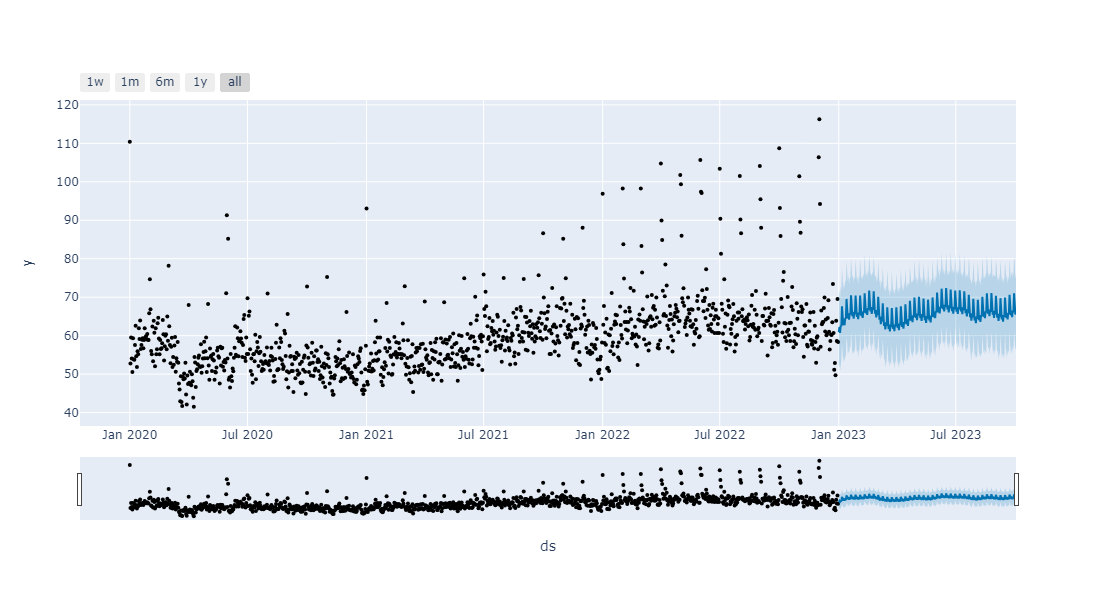

In [81]:
plot_plotly(m,forecast)

#### Actual values from the test set plotted as red dots in the forecast plot

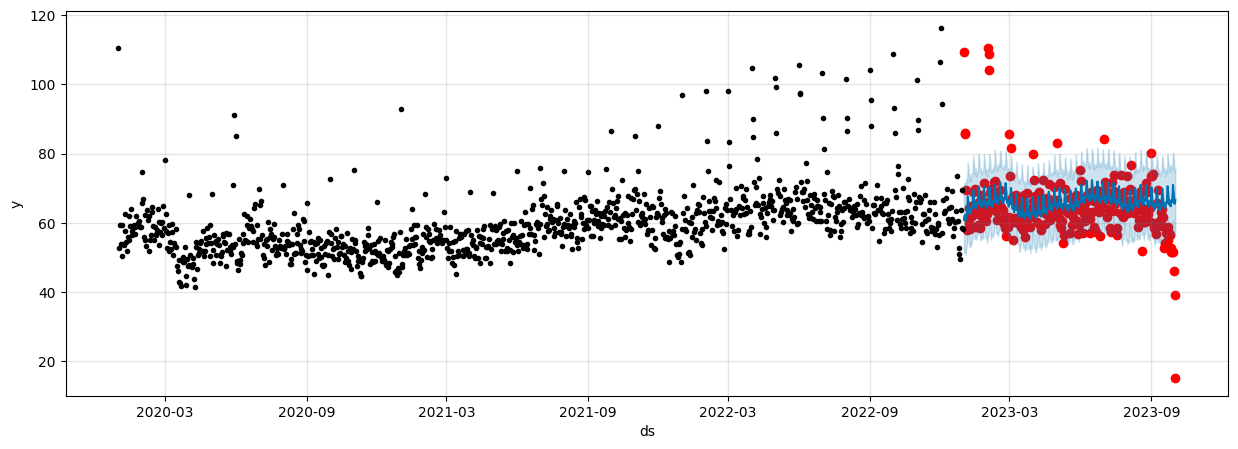

In [82]:
fcast=forecast[['ds','yhat']]
fcast.columns=['Date','Crime Rate Predicted']
test.columns=['Date','Crime Rate Actual']
fcast.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)
fig,ax=plt.subplots(figsize=(15,5))
ax.scatter(test.index,test['Crime Rate Actual'],color='r')
figur=m.plot(forecast,ax=ax)

#### Zoomed in plot between Actual and Predicted Crime Rates

C:\Users\nirmi\AppData\Local\Temp\ipykernel_18016\780206584.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



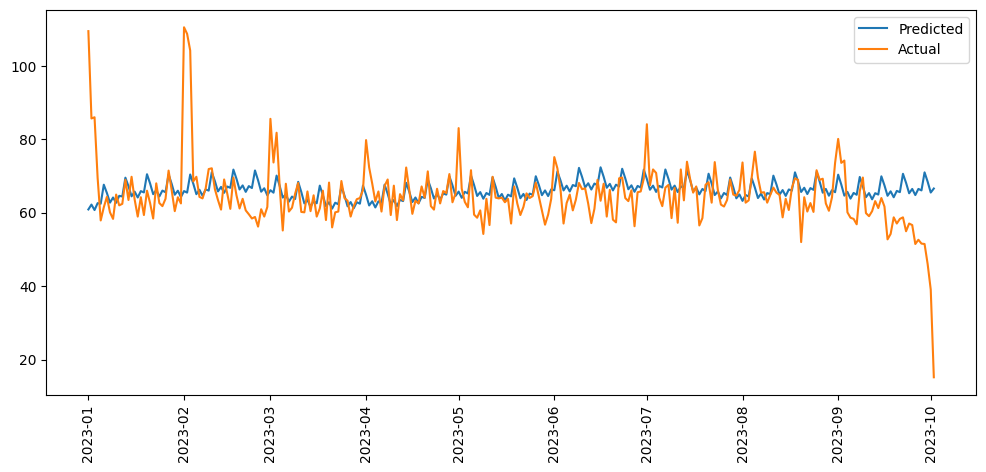

In [83]:
fig,ax=plt.subplots(figsize=(12,5))
predicted=fcast.reset_index()
actual=test.reset_index()
plt.plot(predicted['Date'],predicted['Crime Rate Predicted'], label = "Predicted")
plt.plot(actual['Date'],actual['Crime Rate Actual'], label = "Actual")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.legend()
plt.show()

#### Error Metrics for the Model

In [84]:
mae=mean_absolute_error(test,fcast)
mape=mean_absolute_percentage_error(test,fcast)
rmse=mean_squared_error(test,fcast)

print(f'mae - prophet: {mae}')
print(f'mape - prophet: {mape}')
print(f'rmse - prophet: {rmse}')

mae - prophet: 5.2750597391157
mape - prophet: 0.09025774115682136
rmse - prophet: 75.71045554290579


#### Applying model to predict Crime Rates for the whole year of 2023

In [85]:
future=m.make_future_dataframe(periods=365,freq='D',include_history=False)
forecast=m.predict(future)
forecast.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
360 2023-12-27  65.525161   50.589442   71.205371    62.116194    68.936753   
361 2023-12-28  65.523800   51.042769   70.335982    62.103139    68.953207   
362 2023-12-29  65.522439   55.458229   75.828492    62.098745    68.967606   
363 2023-12-30  65.521078   52.501650   73.506083    62.094698    68.970169   
364 2023-12-31  65.519716   49.347355   69.710747    62.086023    68.974632   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
360       -4.655567             -4.655567             -4.655567 -0.484732   
361       -5.069568             -5.069568             -5.069568 -0.922108   
362       -0.105671             -0.105671             -0.105671  3.978823   
363       -2.550609             -2.550609             -2.550609  1.432331   
364       -5.347585             -5.347585             -5.347585 -1.502984   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
360     -0.484732     -0.484732 -4.170835     -4.170835     -4.170835   
361     -0.922108     -0.922108 -4.147460     -4.147460     -4.147460   
362      3.978823      3.978823 -4.084493     -4.084493     -4.084493   
363      1.432331      1.432331 -3.982940     -3.982940     -3.982940   
364     -1.502984     -1.502984 -3.844601     -3.844601     -3.844601   

     multiplicative_terms  multiplicative_terms_lower  \
360                   0.0                         0.0   
361                   0.0                         0.0   
362                   0.0                         0.0   
363                   0.0                         0.0   
364                   0.0                         0.0   

     multiplicative_terms_upper       yhat  
360                         0.0  60.869594  
361                         0.0  60.454232  
362                         0.0  65.416768  
363                         0.0  62.970469  
364                         0.0  60.172132

#### Visualizing the Forecast

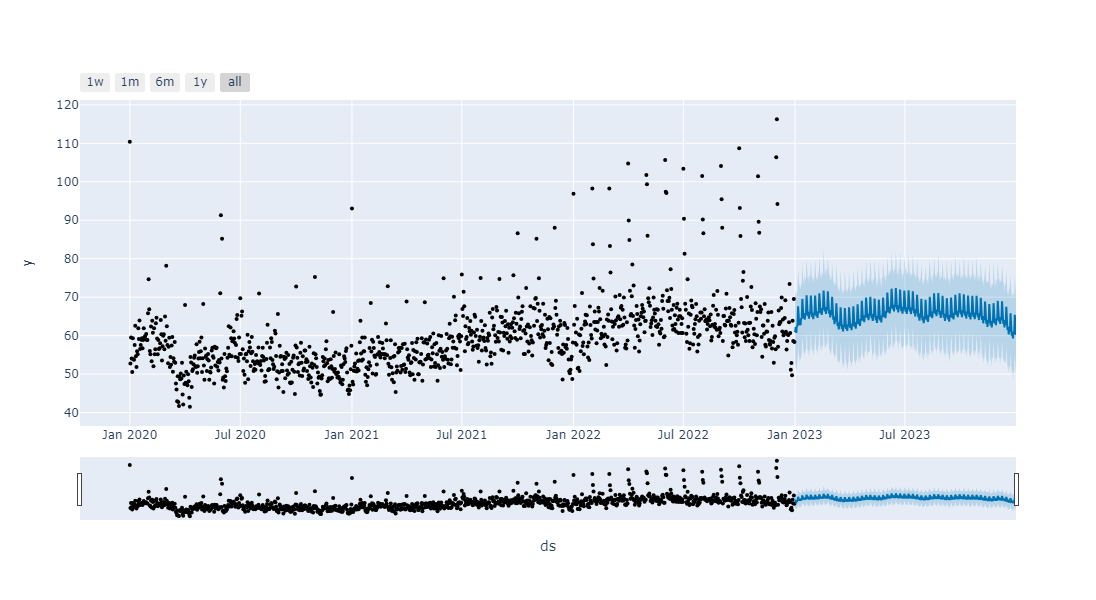

In [86]:
plot_plotly(m,forecast)

In [87]:
print("Forecasted results after Jan 2023 to Dec 2023: ")
predictions_2023=forecast[['ds','yhat']]
predictions_2023.columns=['Date','Crime rate predictions']
predictions_2023.tail(20)

Forecasted results after Jan 2023 to Dec 2023: 


Date  Crime rate predictions
345 2023-12-12               62.121584
346 2023-12-13               63.518633
347 2023-12-14               62.834314
348 2023-12-15               67.477380
349 2023-12-16               64.666967
350 2023-12-17               61.466819
351 2023-12-18               62.321360
352 2023-12-19               60.345307
353 2023-12-20               61.738133
354 2023-12-21               61.084944
355 2023-12-22               65.794676
356 2023-12-23               63.085794
357 2023-12-24               60.020526
358 2023-12-25               61.040968
359 2023-12-26               59.258756
360 2023-12-27               60.869594
361 2023-12-28               60.454232
362 2023-12-29               65.416768
363 2023-12-30               62.970469
364 2023-12-31               60.172132

#### Trends yearly, monthly and weekly

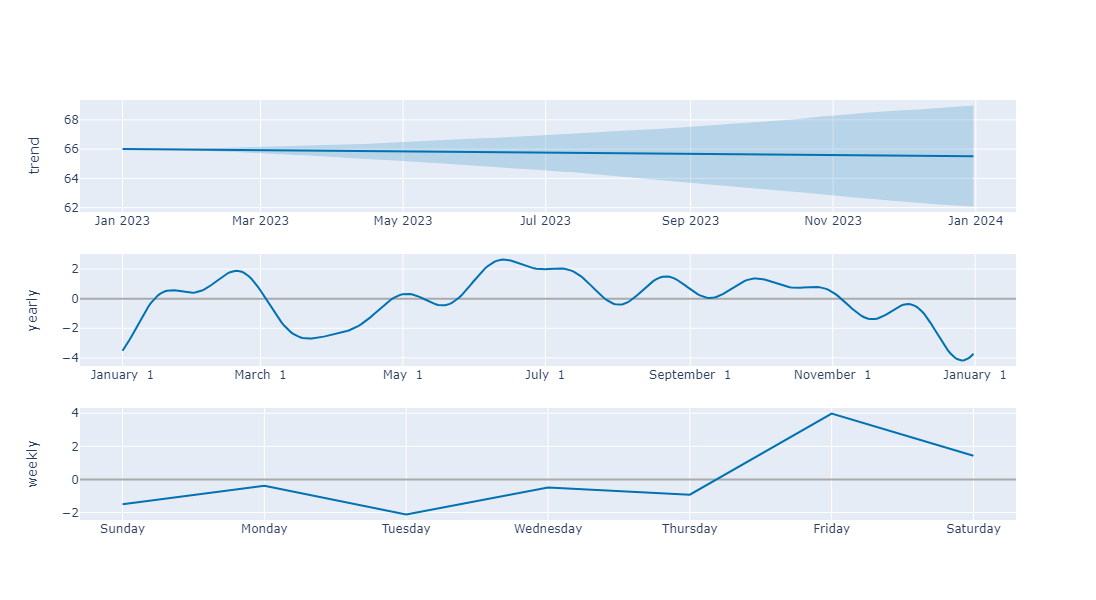

In [88]:
plot_components_plotly(m,forecast)